In [ ]:
import os

from google.colab import drive
drive.mount('/content/drive')
model_dir = '/content/drive/MyDrive/projects/datasets/GDP GROWTH MODEL'
os.makedirs(model_dir, exist_ok=True)


Mounted at /content/drive


# **Importing Libraries and Fetching Data**

In [ ]:
import requests
import pandas as pd
import time
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
!pip install xgboost
!pip install shap

In [ ]:
base_url="https://api.worldbank.org/v2/countries/all/indicators/"

In [ ]:
all_data = []
page=1
session=requests.session()
indicators = {
    "GDP Growth (%)": "NY.GDP.MKTP.KD.ZG",
    "Agriculture Growth (%)": "NV.AGR.TOTL.KD.ZG",
    "Industry Growth (%)": "NV.IND.TOTL.KD.ZG",
    "Manufacturing Growth (%)": "NV.IND.MANF.KD.ZG",
    "Services Growth (%)": "NV.SRV.TOTL.KD.ZG",
    "Exports Growth (%)": "NE.EXP.GNFS.KD.ZG",
    "Imports Growth (%)": "NE.IMP.GNFS.KD.ZG",
    "Foreign Direct Investment (% of GDP)": "BX.KLT.DINV.WD.GD.ZS",
    "Final Consumption Growth (%)": "NE.CON.TOTL.KD.ZG",
    "Gross Capital Formation Growth (%)": "NE.GDI.TOTL.KD.ZG",
    "Unemployment Rate (%)": "SL.UEM.TOTL.ZS",
    "GDP per person employed ($, PPP)": "SL.GDP.PCAP.EM.KD",
    "Inflation (CPI)": "FP.CPI.TOTL"
}

In [ ]:
for indicator_name,indicator_code in indicators.items():
  page=1
  print(f"fetching data for {indicator_name}")
  while True:
    try:
      print(f"fetching page{page}...")
      response=session.get(base_url+indicator_code,params={"format":"json","per_page":1000,"page":page},timeout=10)
      data=response.json()
      if len(data)<2 or not data[1] :
        break
      for item in data[1]:
        if item["value"] is not None:
          all_data.append({
            "Country":item["country"]["value"],
            "Year":int(item["date"]),
            "Value":float(item["value"]),
            "indicator":indicator_name
          })
      page+=1
      '''time.sleep(1)'''
    except Exception as e:
      print(f"Error fetching data for {indicator_name}: {e}")
      break
session.close()

fetching data for GDP Growth (%)
fetching page1...
fetching page2...
fetching page3...
fetching page4...
fetching page5...
fetching page6...
fetching page7...
fetching page8...
fetching page9...
fetching page10...
fetching page11...
fetching page12...
fetching page13...
fetching page14...
fetching page15...
fetching page16...
fetching page17...
fetching page18...
fetching page19...
fetching data for Agriculture Growth (%)
fetching page1...
fetching page2...
fetching page3...
fetching page4...
fetching page5...
fetching page6...
fetching page7...
fetching page8...
fetching page9...
fetching page10...
fetching page11...
fetching page12...
fetching page13...
fetching page14...
fetching page15...
fetching page16...
fetching page17...
fetching page18...
fetching page19...
fetching data for Industry Growth (%)
fetching page1...
fetching page2...
fetching page3...
fetching page4...
fetching page5...
fetching page6...
fetching page7...
fetching page8...
fetching page9...
fetching page10...
fet

In [ ]:
df=pd.DataFrame(all_data)


In [ ]:
df_pivot=df.pivot_table(index=["Country","Year"],columns="indicator",values="Value").reset_index()
df_pivot=df_pivot.loc[:,~df_pivot.columns.duplicated()]

# **Basic data insights**

In [ ]:
df_pivot.head()

indicator,Country,Year,Agriculture Growth (%),Exports Growth (%),Final Consumption Growth (%),Foreign Direct Investment (% of GDP),GDP Growth (%),"GDP per person employed ($, PPP)",Gross Capital Formation Growth (%),Imports Growth (%),Industry Growth (%),Inflation (CPI),Manufacturing Growth (%),Services Growth (%),Unemployment Rate (%)
0,Afghanistan,1991,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.070
1,Afghanistan,1992,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.011
2,Afghanistan,1993,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.888
3,Afghanistan,1994,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.822
4,Afghanistan,1995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.817


In [ ]:
df_pivot.info()
df_pivot.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14689 entries, 0 to 14688
Data columns (total 15 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Country                               14689 non-null  object 
 1   Year                                  14689 non-null  int64  
 2   Agriculture Growth (%)                10022 non-null  float64
 3   Exports Growth (%)                    8654 non-null   float64
 4   Final Consumption Growth (%)          8675 non-null   float64
 5   Foreign Direct Investment (% of GDP)  11520 non-null  float64
 6   GDP Growth (%)                        13883 non-null  float64
 7   GDP per person employed ($, PPP)      7361 non-null   float64
 8   Gross Capital Formation Growth (%)    7828 non-null   float64
 9   Imports Growth (%)                    8678 non-null   float64
 10  Industry Growth (%)                   9666 non-null   float64
 11  Inflation (CPI)

indicator,Year,Agriculture Growth (%),Exports Growth (%),Final Consumption Growth (%),Foreign Direct Investment (% of GDP),GDP Growth (%),"GDP per person employed ($, PPP)",Gross Capital Formation Growth (%),Imports Growth (%),Industry Growth (%),Inflation (CPI),Manufacturing Growth (%),Services Growth (%),Unemployment Rate (%)
count,14689.000000,10022.000000,8654.000000,8675.000000,11520.000000,13883.000000,7361.000000,7828.000000,8678.000000,9666.000000,9.044000e+03,8327.000000,9036.000000,7981.000000
mean,1994.970863,2.605208,5.985076,3.743242,4.798658,3.673056,46126.793918,5.838121,5.828325,3.833575,9.514946e+01,3.754128,4.140894,7.859274
std,17.932053,10.692762,20.418488,7.819728,39.884703,6.169865,44654.962712,32.099466,14.658110,9.876256,6.800935e+02,15.359513,6.675144,5.577883
min,1960.000000,-65.959443,-96.364419,-40.868215,-1303.108267,-64.047107,1150.461179,-938.995687,-94.700000,-80.296779,3.546558e-14,-79.646665,-100.000000,0.100000
25%,1980.000000,-0.706881,0.000000,1.533513,0.446734,1.405401,12060.704035,-2.664951,-0.755265,0.070251,1.917258e+01,-0.123599,1.856645,4.067000
50%,1996.000000,2.720079,5.133382,3.568868,1.515728,3.808982,32422.903678,4.566718,5.403719,3.713856,6.726629e+01,3.526896,4.094118,6.306455
75%,2010.000000,5.483132,10.489979,5.783444,3.571305,6.118590,65049.075401,11.844222,11.709008,7.389401,1.052259e+02,7.238423,6.486422,10.322000
max,2024.000000,547.393678,1045.449294,393.570492,1709.827232,149.972963,316742.412899,1005.916401,328.685257,196.074936,3.879656e+04,913.135187,181.844723,38.800000


In [ ]:
print(df_pivot[df_pivot["GDP Growth (%)"]>100])

indicator            Country  Year  Agriculture Growth (%)  \
3774       Equatorial Guinea  1997                     NaN   
7725                 Liberia  1997                     NaN   

indicator  Exports Growth (%)  Final Consumption Growth (%)  \
3774                      NaN                           NaN   
7725                      NaN                           NaN   

indicator  Foreign Direct Investment (% of GDP)  GDP Growth (%)  \
3774                                  12.083869      149.972963   
7725                                  72.260899      106.279814   

indicator  GDP per person employed ($, PPP)  \
3774                           22383.025560   
7725                            2599.072972   

indicator  Gross Capital Formation Growth (%)  Imports Growth (%)  \
3774                                      NaN                 NaN   
7725                                      NaN                 NaN   

indicator  Industry Growth (%)  Inflation (CPI)  Manufacturing Growth (

In [ ]:
print(f"Total countries: {df_pivot['Country'].nunique()}")
print(f"Time range: {df_pivot['Year'].min()} to {df_pivot['Year'].max()}")
print(f"Available indicators: {len(indicators)}")

Total countries: 263
Time range: 1960 to 2024
Available indicators: 13


# **Visualising Missing values**(before imputation)

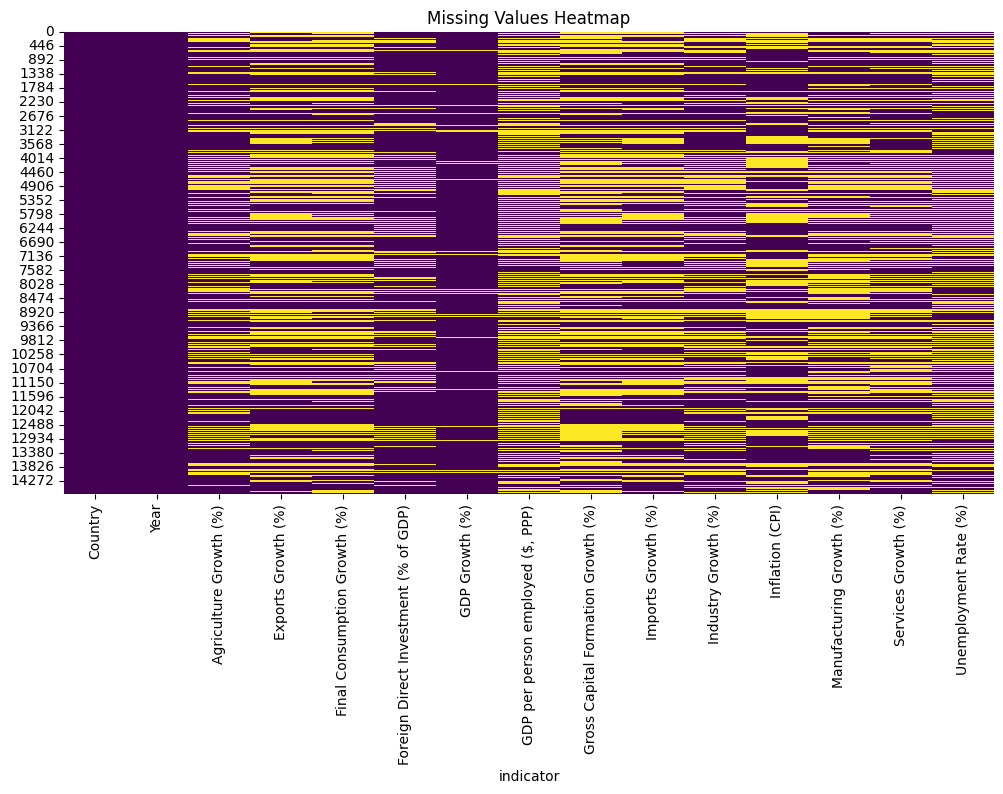

In [ ]:
#visualisig missing data(before imputation) using heatmap
def plot_missing_heatmap(df, title="Missing Values Heatmap", figsize=(12, 6), cmap='viridis'):
    plt.figure(figsize=figsize)
    sns.heatmap(df.isnull(), cbar=False, cmap=cmap)
    plt.title(title)
    plt.show()

plot_missing_heatmap(df_pivot, title="Missing Values Heatmap")


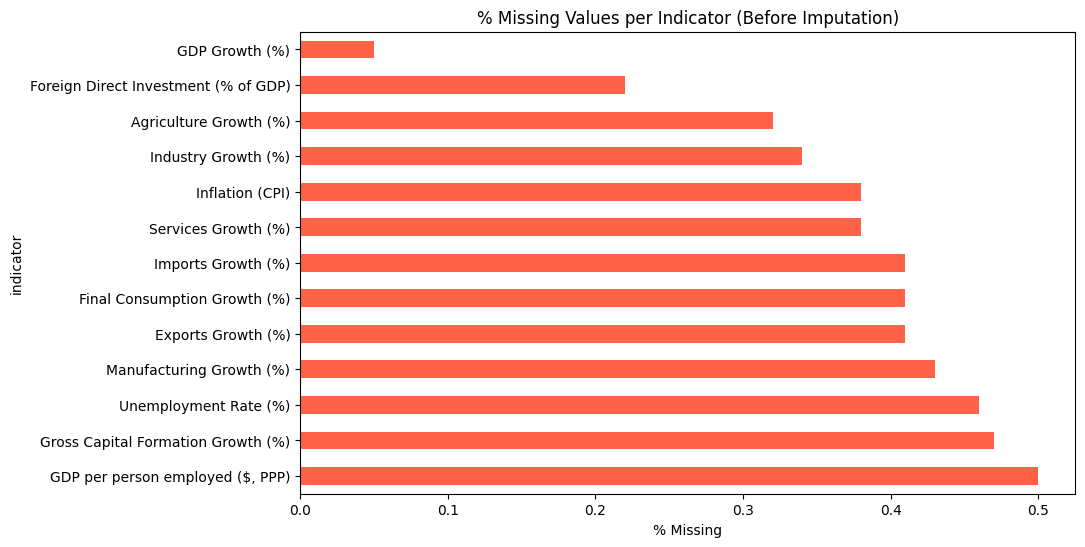

In [ ]:
#visualising missing data(before imputation) using barmap
missing_percentage = df_pivot.isnull().mean().sort_values(ascending=False).round(2)
missing_percentage[missing_percentage > 0].plot(kind='barh', figsize=(10, 6), color='tomato')
plt.title("% Missing Values per Indicator (Before Imputation)")
plt.xlabel("% Missing")
plt.show()

In [ ]:
#missing values percentage
missing_values = df_pivot.isnull().sum().sort_values(ascending=False)
missing_df=pd.DataFrame({
    "Missing Values":missing_values,
    "Missing Percentage":missing_percentage
})
print("Missing Values per Indicator:\n", missing_df)




Missing Values per Indicator:
                                       Missing Values  Missing Percentage
indicator                                                               
GDP per person employed ($, PPP)                7328                0.50
Gross Capital Formation Growth (%)              6861                0.47
Unemployment Rate (%)                           6708                0.46
Manufacturing Growth (%)                        6362                0.43
Exports Growth (%)                              6035                0.41
Final Consumption Growth (%)                    6014                0.41
Imports Growth (%)                              6011                0.41
Services Growth (%)                             5653                0.38
Inflation (CPI)                                 5645                0.38
Industry Growth (%)                             5023                0.34
Agriculture Growth (%)                          4667                0.32
Foreign Direct Inves

# **Detecting and Handling Outliers**

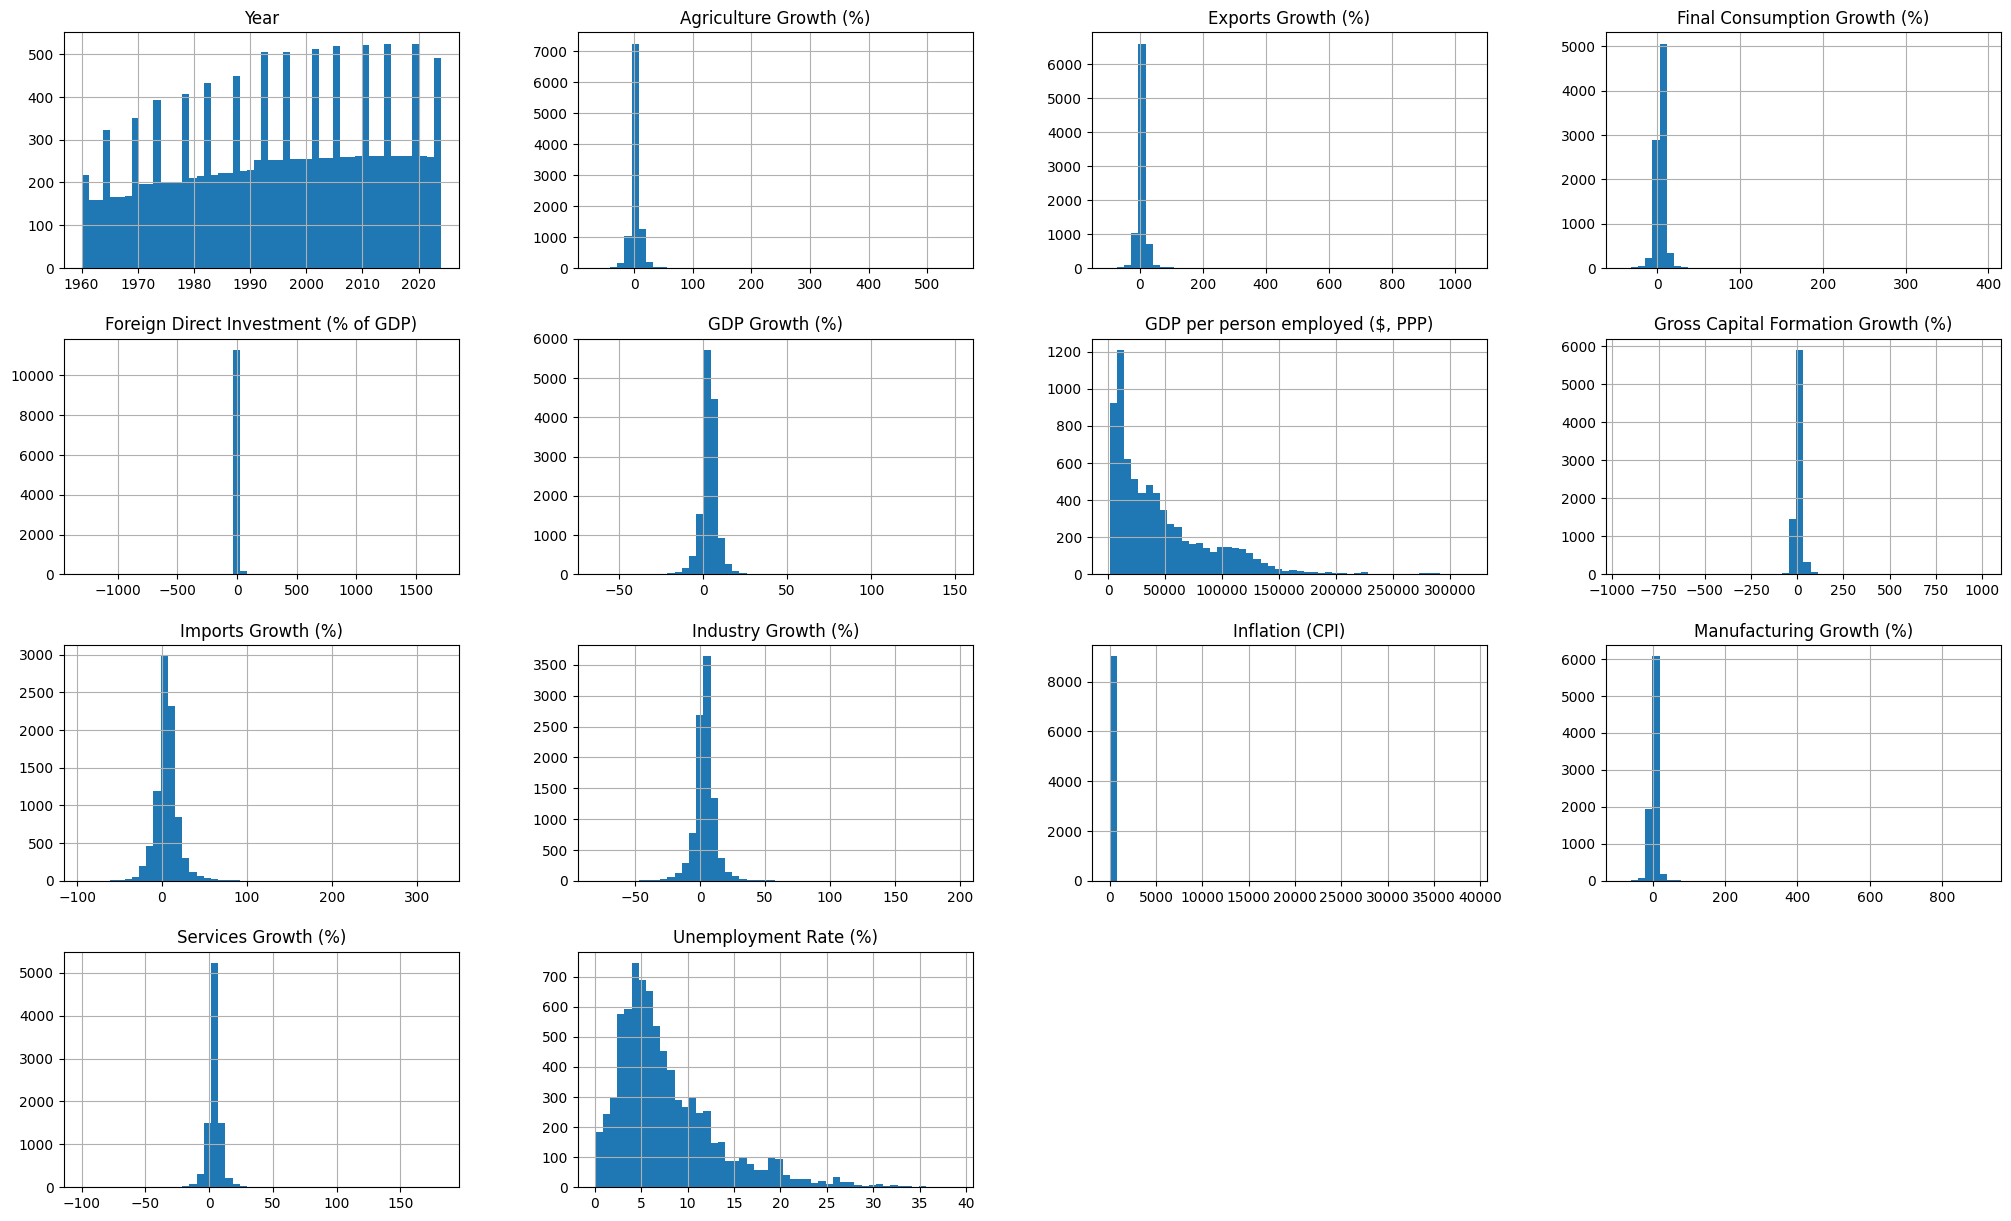

In [ ]:
# histogram to see skewness
def plot_numeric_histograms(df):
    numeric_df = df.select_dtypes(include='number')
    ax = numeric_df.hist(bins=50, figsize=(25, 15))
    plt.show()

plot_numeric_histograms(df_pivot)


In [ ]:
def detect_outliers(df, numeric_cols):
    outliers = {}
    df_outliers_count = df.copy()
    for col in numeric_cols:
        Q1 = df_outliers_count[col].quantile(0.25)
        Q3 = df_outliers_count[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers[col] = df_outliers_count[(df_outliers_count[col] < lower_bound) | (df_outliers_count[col] > upper_bound)].shape[0]

    outlier_counts = pd.DataFrame.from_dict(outliers, orient='index', columns=['Outlier Count'])
    outlier_counts = outlier_counts.sort_values(by='Outlier Count', ascending=False)
    return outlier_counts

numeric_cols = df_pivot.select_dtypes(include='number').columns
outlier_counts = detect_outliers(df_pivot, numeric_cols)
print(outlier_counts)


                                      Outlier Count
Foreign Direct Investment (% of GDP)           1099
Agriculture Growth (%)                         1044
GDP Growth (%)                                  993
Exports Growth (%)                              770
Final Consumption Growth (%)                    736
Industry Growth (%)                             715
Gross Capital Formation Growth (%)              700
Services Growth (%)                             660
Manufacturing Growth (%)                        634
Imports Growth (%)                              578
Unemployment Rate (%)                           357
GDP per person employed ($, PPP)                224
Inflation (CPI)                                 197
Year                                              0


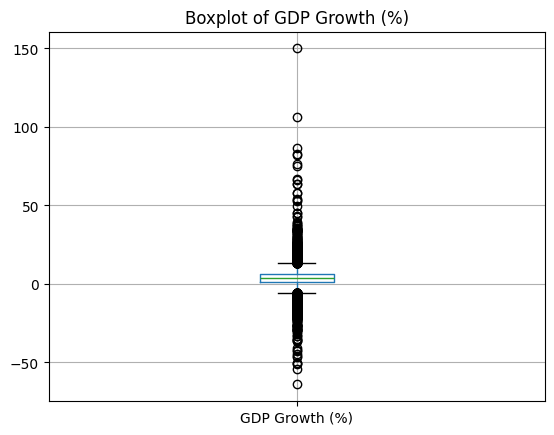

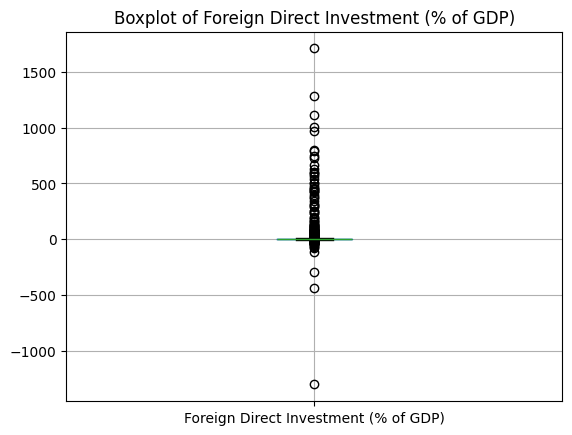

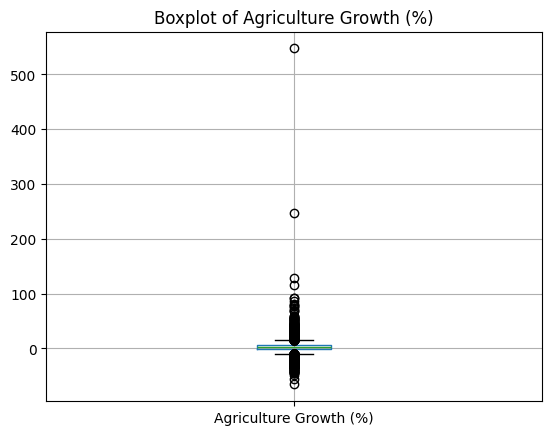

In [ ]:
# Box plot for spotting outliers
def plot_boxplots(df, columns, title_prefix=""):
    for col in columns:
        if col in df.columns:
            df.boxplot(column=col)
            plt.title(f"Boxplot of {col}")
            plt.show()
        else:
            print(f"⚠️ Column '{col}' not found in DataFrame.")
columns_to_plot = [
    "GDP Growth (%)",
    "Foreign Direct Investment (% of GDP)",
    "Agriculture Growth (%)"
]

plot_boxplots(df_pivot, columns_to_plot)


In [ ]:
print(df_pivot['GDP Growth (%)'].mean())
print(df_pivot['GDP Growth (%)'].median())

3.673055520522311
3.80898237635019


In [ ]:
df_pivot=df_pivot[df_pivot["GDP Growth (%)"]<1000]

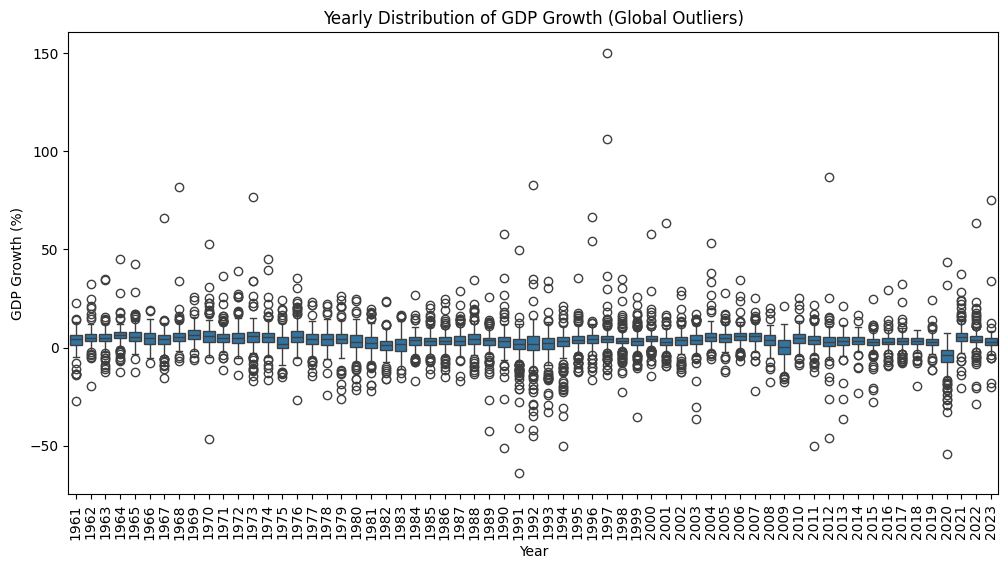

In [ ]:
# Boxplot of GDP growth by year
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_pivot, x='Year', y='GDP Growth (%)')
plt.xticks(rotation=90)
plt.title('Yearly Distribution of GDP Growth (Global Outliers)')
plt.show()


 Handling Outliers

In [ ]:
# Remove extreme outliers using IQR method
def remove_outliers(df, numeric_cols):
    """
    Removes rows with outliers from the dataframe based on the IQR method.
    """
    df_no_outliers = df.copy()

    for col in numeric_cols:
        Q1 = df_no_outliers[col].quantile(0.25)
        Q3 = df_no_outliers[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        df_no_outliers = df_no_outliers[(df_no_outliers[col] >= lower) & (df_no_outliers[col] <= upper)]

    return df_no_outliers

# Example usage:
df_no_outliers = remove_outliers(df_pivot, df_pivot.select_dtypes(include='number').columns)


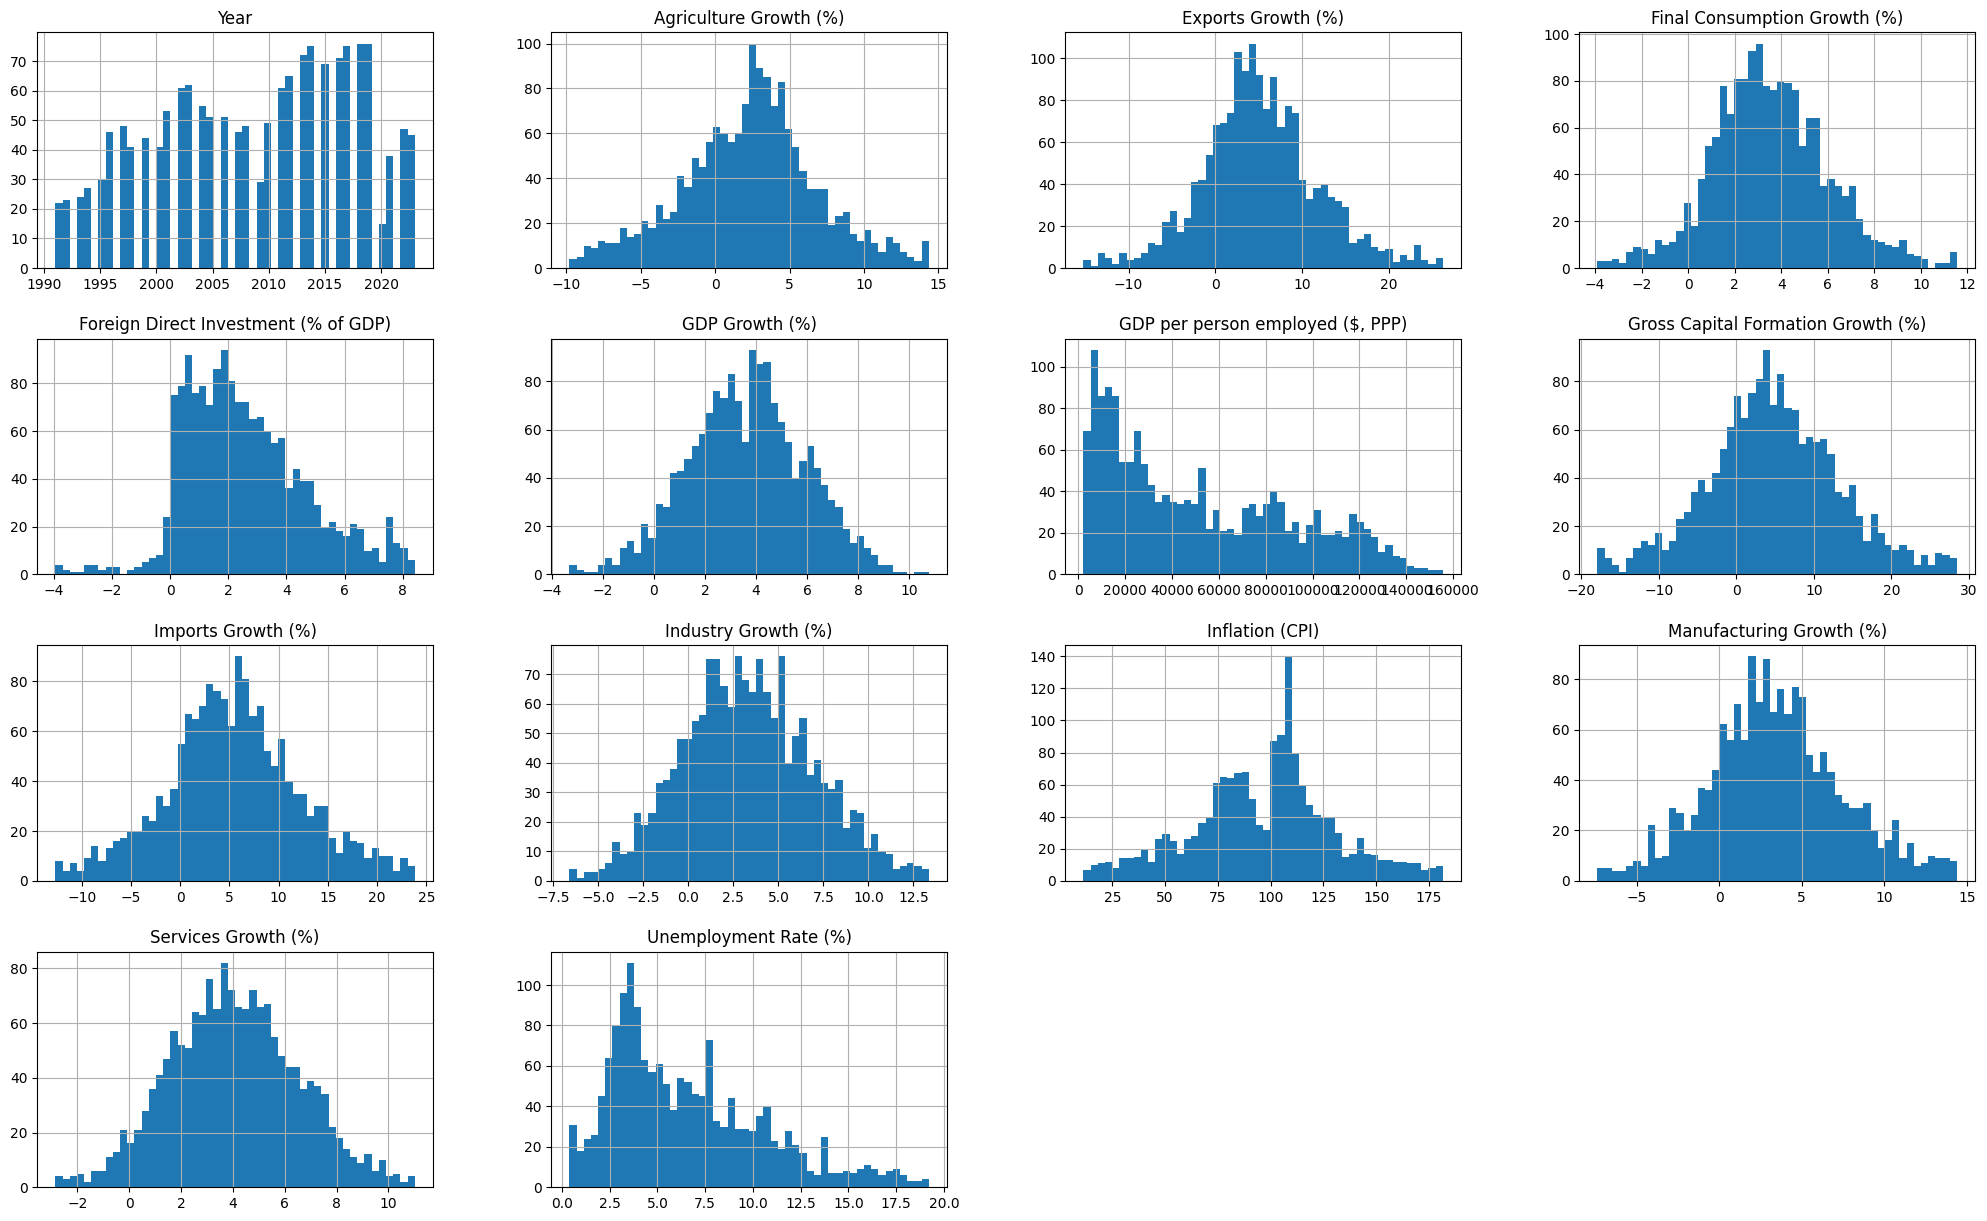

In [ ]:
# histogram to see skewness
plot_numeric_histograms(df_no_outliers)


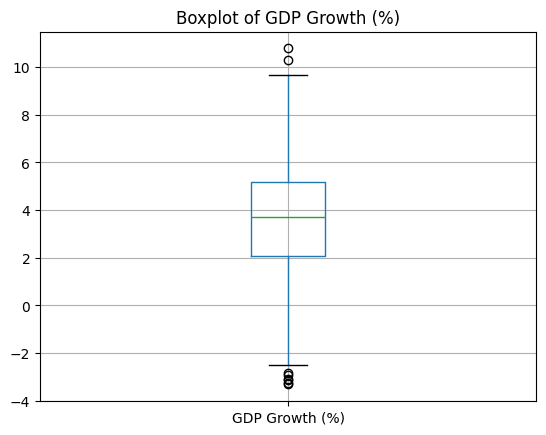

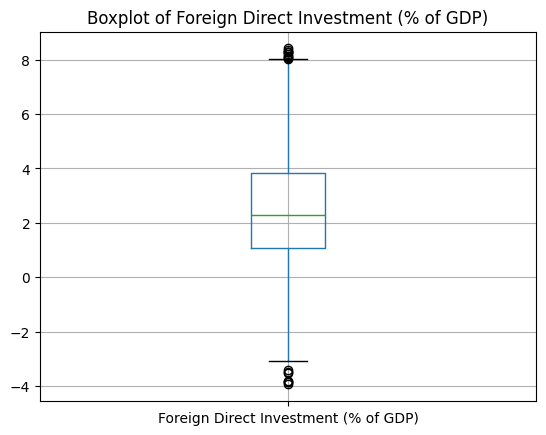

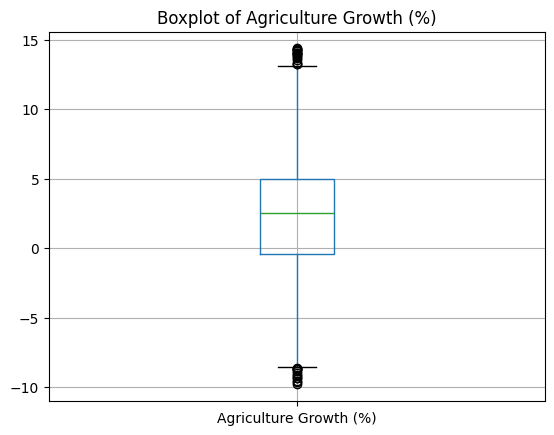

In [ ]:
# Box plot for spotting outliers
plot_boxplots(df_no_outliers, columns_to_plot)

In [ ]:
# cap outliers instead of removing them
def cap_outliers(df, numeric_cols, lower_percentile=0.01, upper_percentile=0.99):
    """
    Caps outliers by limiting values to the specified percentiles.
    """
    df_capped = df.copy()

    for col in numeric_cols:
        lower_limit = df_capped[col].quantile(lower_percentile)
        upper_limit = df_capped[col].quantile(upper_percentile)
        df_capped[col] = df_capped[col].clip(lower=lower_limit, upper=upper_limit)

    return df_capped

# Example usage:
df_capped = cap_outliers(df_pivot, df_pivot.select_dtypes(include='number').columns)



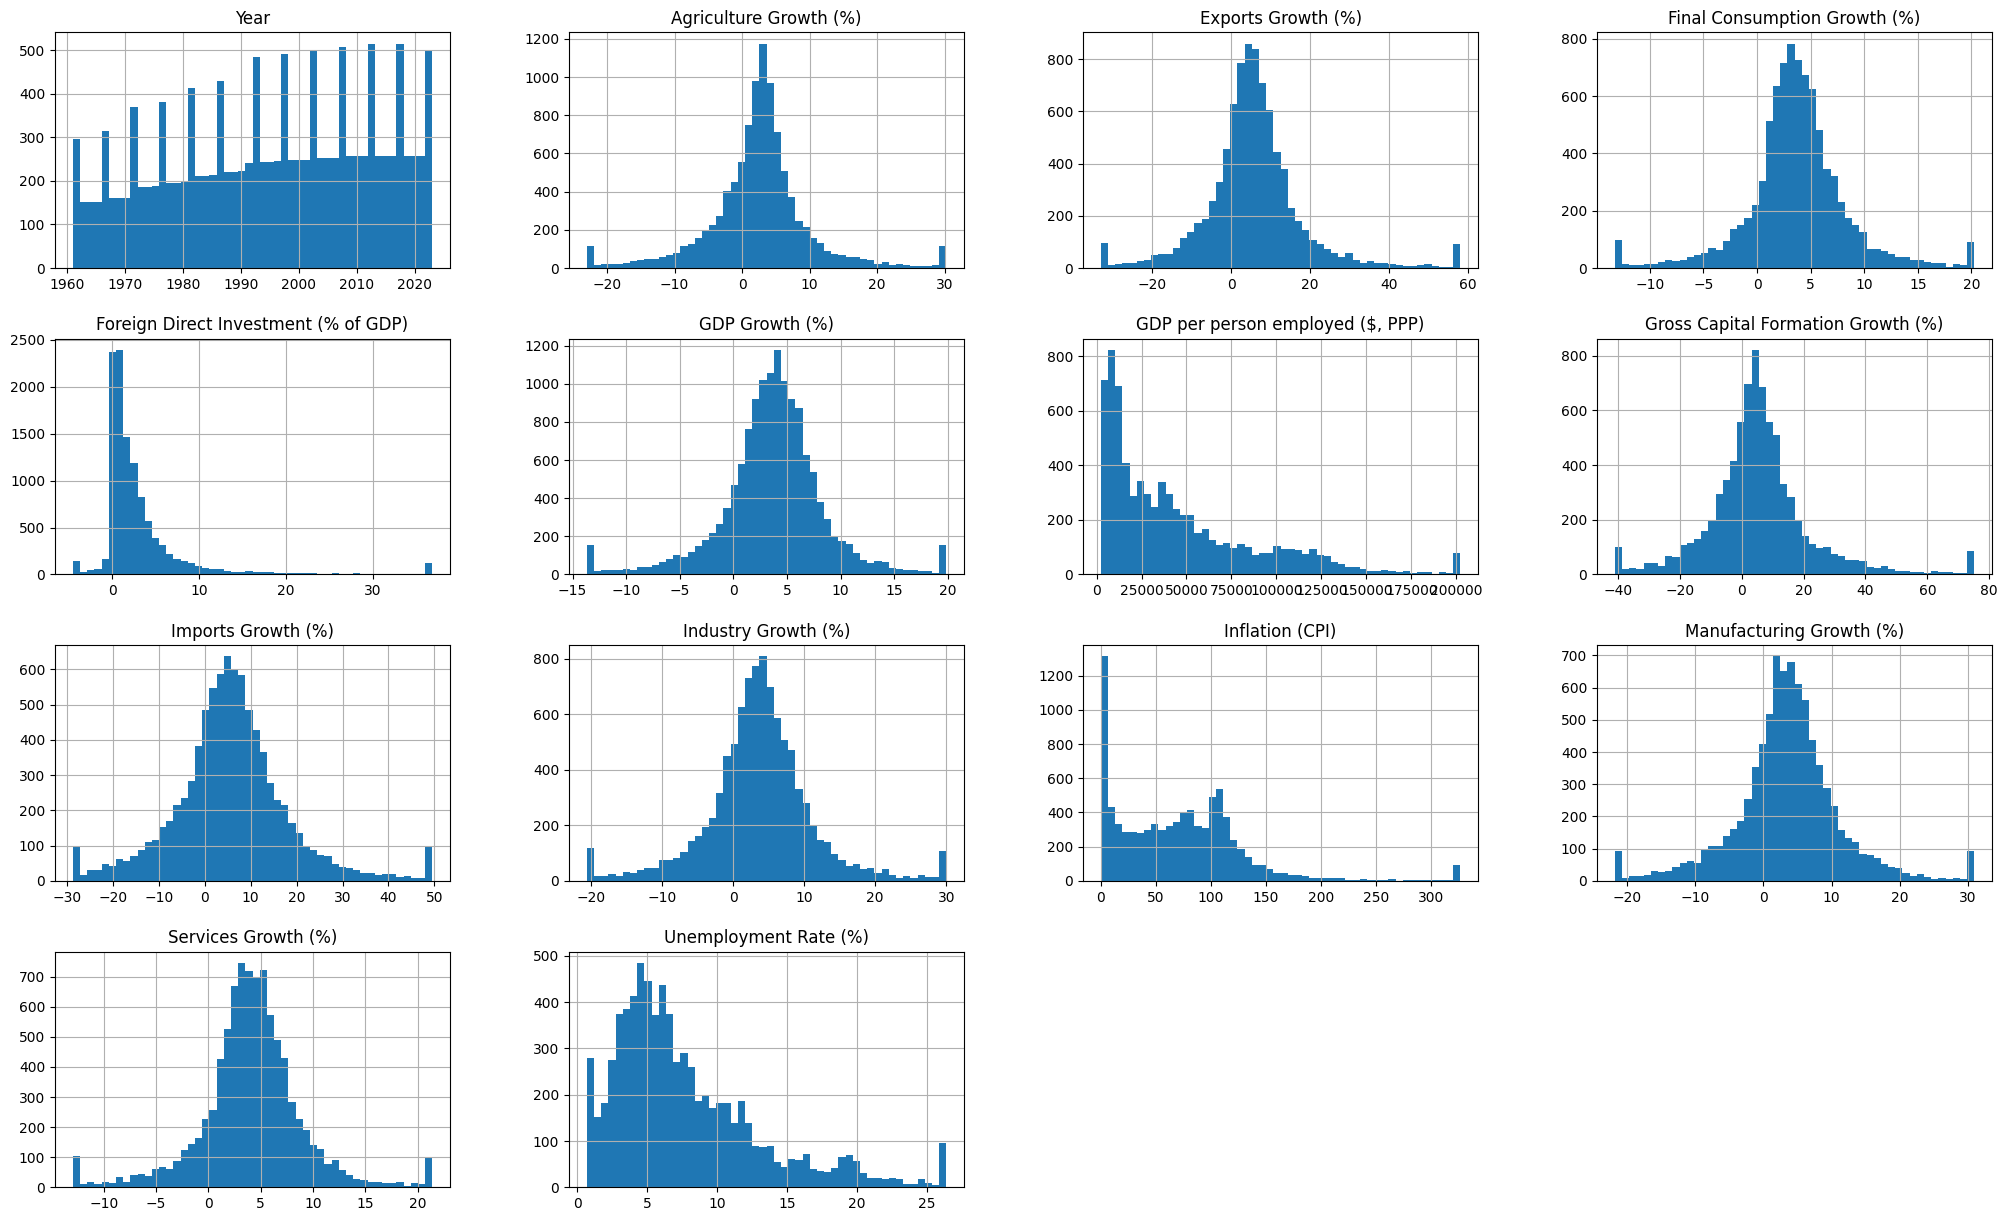

In [ ]:
# histogram to see skewness
plot_numeric_histograms(df_capped)


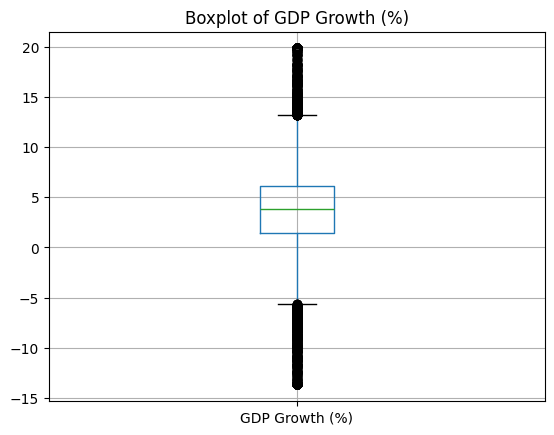

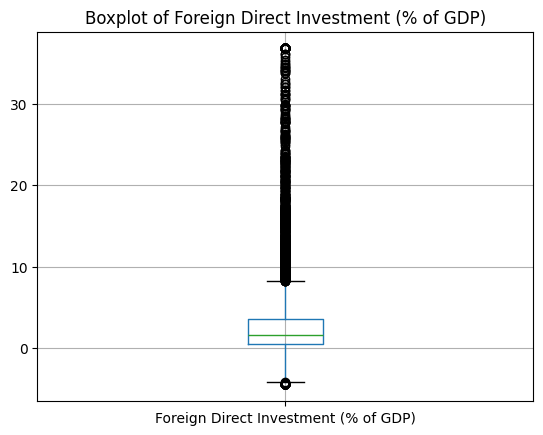

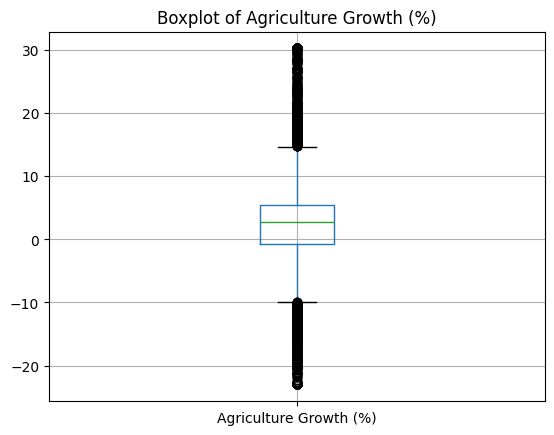

In [ ]:
# Box plot for spotting outliers
plot_boxplots(df_capped, columns_to_plot)

# **Handling Missing Values**

In [ ]:
#Handling missing values
if "Unemployment Rate (%)" in df_pivot.columns and "GDP per person employed ($, PPP)" in df_pivot.columns:
  df_pivot=df_pivot.drop(columns=["Unemployment Rate (%)","GDP per person employed ($, PPP)"])
df_pivot = df_pivot.sort_values(by=["Country", "Year"])
df_pivot = df_pivot.groupby("Country").apply(lambda group: group.ffill().bfill()).reset_index(drop=True)
fill_year_median = [
    "Agriculture Growth (%)", "Industry Growth (%)", "Services Growth (%)",
    "Foreign Direct Investment (% of GDP)"
]
for col in fill_year_median:
    df_pivot[col] = df_pivot.groupby("Year")[col].transform(lambda x: x.fillna(x.median()))

# Impute Inflation (CPI) using median per year (cross-country trends)
df_pivot["Inflation (CPI)"] = df_pivot.groupby("Year")["Inflation (CPI)"].transform(lambda x: x.fillna(x.median()))

# Exports, Imports, Final Consumption, Gross Capital, Manufacturing — per year median
median_year_impute = [
    "Exports Growth (%)", "Imports Growth (%)", "Final Consumption Growth (%)",
    "Gross Capital Formation Growth (%)", "Manufacturing Growth (%)"
]
for col in median_year_impute:
    df_pivot[col] = df_pivot.groupby("Year")[col].transform(lambda x: x.fillna(x.median()))

<ipython-input-26-11346818>:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_pivot = df_pivot.groupby("Country").apply(lambda group: group.ffill().bfill()).reset_index(drop=True)


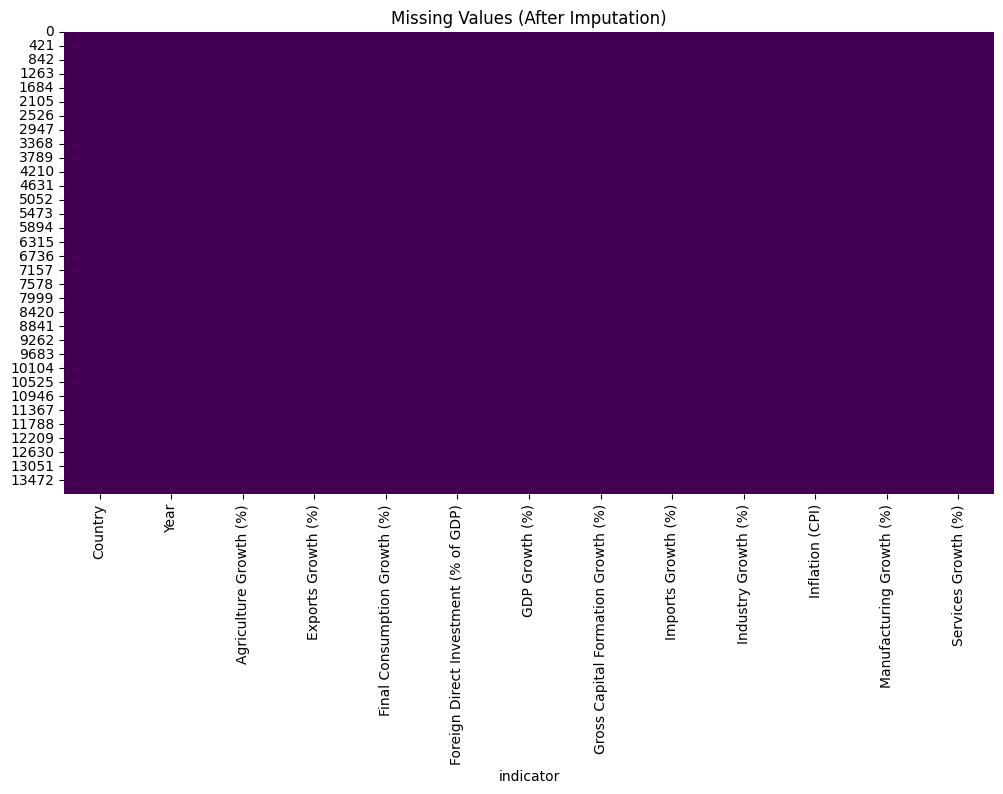

In [ ]:
#Visualize Missing Values(After Imputation) using heatmap
plot_missing_heatmap(df_pivot, title="Missing Values (After Imputation)")


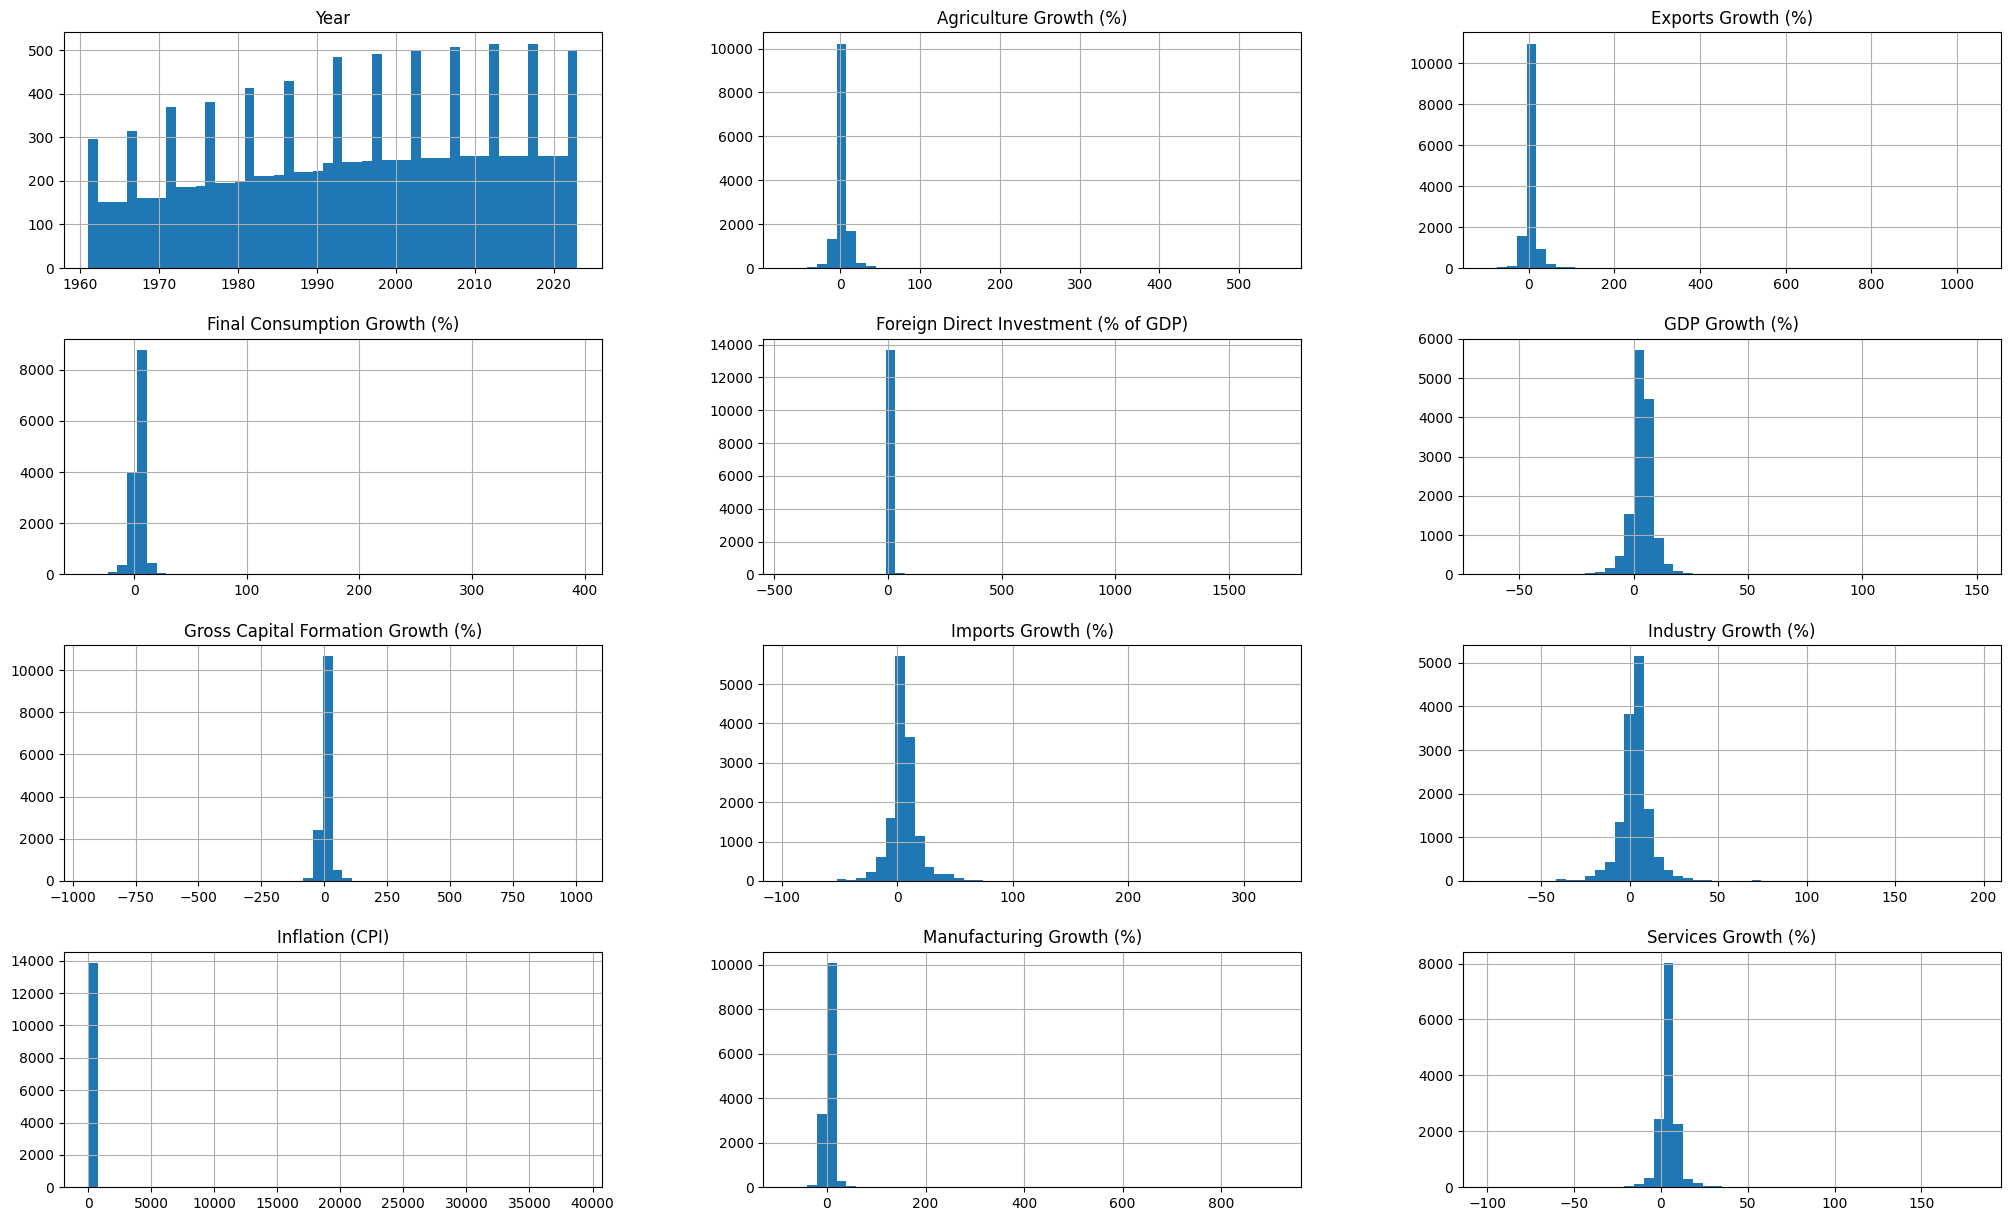

In [ ]:
# histogram to see skewness
plot_numeric_histograms(df_pivot)


In [ ]:
print(df_pivot.isnull().mean()*100)

indicator
Country                                 0.0
Year                                    0.0
Agriculture Growth (%)                  0.0
Exports Growth (%)                      0.0
Final Consumption Growth (%)            0.0
Foreign Direct Investment (% of GDP)    0.0
GDP Growth (%)                          0.0
Gross Capital Formation Growth (%)      0.0
Imports Growth (%)                      0.0
Industry Growth (%)                     0.0
Inflation (CPI)                         0.0
Manufacturing Growth (%)                0.0
Services Growth (%)                     0.0
dtype: float64


# **EDA**


Global Economic Trends Analysis


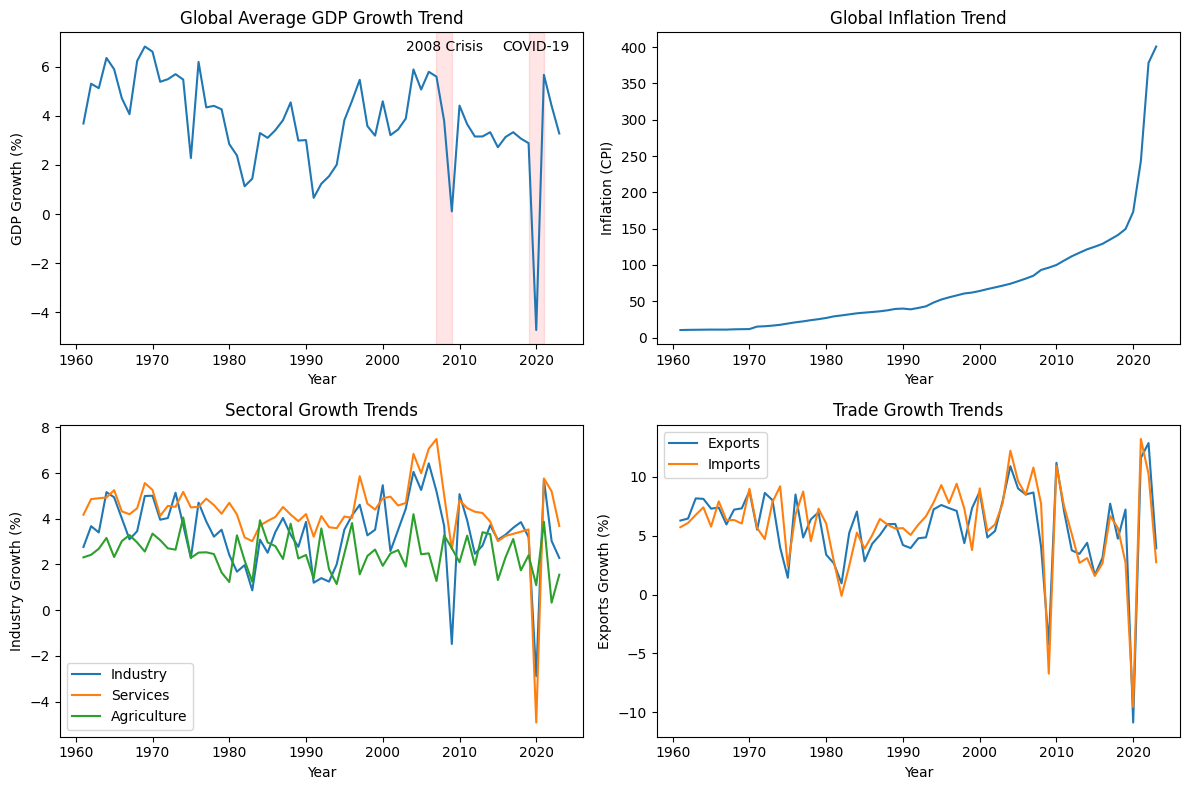

In [ ]:
print("\n" + "="*50)
print("Global Economic Trends Analysis")
print("="*50)

df_pivot['Decade'] = (df_pivot['Year'] // 10) * 10

global_avg = df_pivot.groupby('Year').mean(numeric_only=True).reset_index()

crisis_periods = {
    '2008 Crisis': (2007, 2009),
    'COVID-19': (2019, 2021)
}
plt.figure(figsize=(12,8))
plt.subplot(2, 2, 1)
ax=sns.lineplot(data=global_avg, x='Year', y='GDP Growth (%)')
plt.title('Global Average GDP Growth Trend')
for name, (start, end) in crisis_periods.items():
    ax.axvspan(start, end, color='red', alpha=0.1)
    ax.text((start+end)/2, ax.get_ylim()[1]*0.9, name, ha='center')

plt.subplot(2, 2, 2)
sns.lineplot(data=global_avg, x='Year', y='Inflation (CPI)')
plt.title('Global Inflation Trend')

plt.subplot(2, 2, 3)
sns.lineplot(data=global_avg, x='Year', y='Industry Growth (%)', label='Industry')
sns.lineplot(data=global_avg, x='Year', y='Services Growth (%)', label='Services')
sns.lineplot(data=global_avg, x='Year', y='Agriculture Growth (%)', label='Agriculture')
plt.title('Sectoral Growth Trends')
plt.legend()

plt.subplot(2, 2, 4)
sns.lineplot(data=global_avg, x='Year', y='Exports Growth (%)', label='Exports')
sns.lineplot(data=global_avg, x='Year', y='Imports Growth (%)', label='Imports')
plt.title('Trade Growth Trends')
plt.legend()

plt.tight_layout()
plt.show()

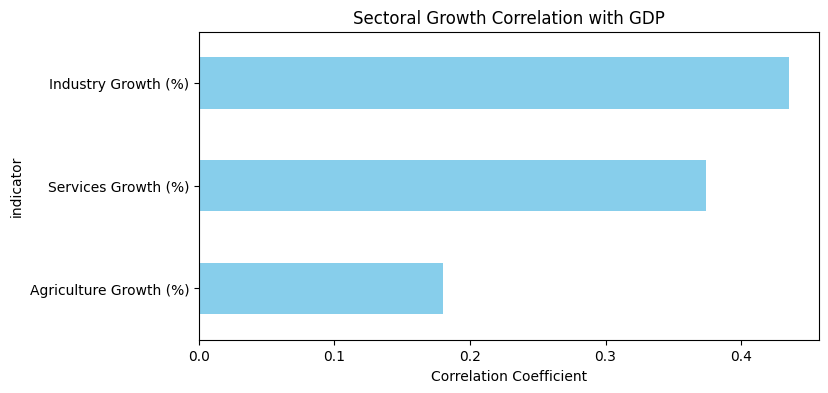

In [ ]:
# Compare sector growth correlations with GDP
sector_columns = ['Agriculture Growth (%)', 'Industry Growth (%)', 'Services Growth (%)']
sector_corr = df_pivot[sector_columns + ['GDP Growth (%)']].corr()['GDP Growth (%)'].drop('GDP Growth (%)')

plt.figure(figsize=(8, 4))
sector_corr.sort_values().plot(kind='barh', color='skyblue')
plt.title('Sectoral Growth Correlation with GDP')
plt.xlabel('Correlation Coefficient')
plt.show()

<ipython-input-32-2873844316>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_gdp, y="Country", x="GDP Growth (%)", palette="coolwarm")


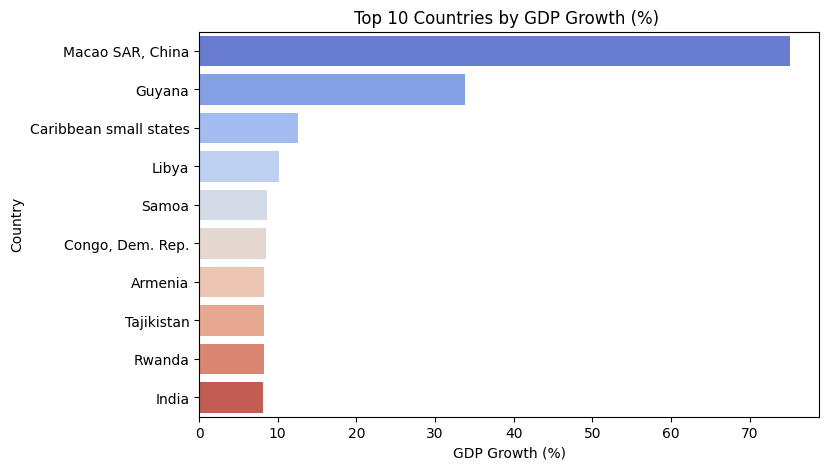

In [ ]:
# Top 10 countries by GDP Growth
top_gdp = df_pivot[df_pivot["Year"] == 2023][["Country", "GDP Growth (%)"]].dropna().sort_values(by="GDP Growth (%)", ascending=False).head(10)

plt.figure(figsize=(8, 5))
sns.barplot(data=top_gdp, y="Country", x="GDP Growth (%)", palette="coolwarm")
plt.title("Top 10 Countries by GDP Growth (%) ")
plt.show()


In [ ]:
import plotly.express as px
import plotly.graph_objects as go
df_latest = df_pivot[df_pivot["Year"] == 2020]

fig = px.choropleth(
    df_latest,
    locations="Country",
    locationmode="country names",
    color="GDP Growth (%)",
    hover_name="Country",
    color_continuous_scale="Viridis",
    title=f"GDP Growth (%) by Country ",
    range_color=[-10, 15]
)

fig.update_layout(
    geo=dict(showframe=False, showcoastlines=False),
    margin=dict(l=0, r=0, t=50, b=0)
)

fig.show()


# **Feature Engineering**

In [ ]:
# Net trade and trade openness
df_pivot['Net Trade (%)'] = df_pivot['Exports Growth (%)'] - df_pivot['Imports Growth (%)']
df_pivot['Trade Openness'] = df_pivot['Exports Growth (%)'] + df_pivot['Imports Growth (%)']

df_pivot['Primary Sector Share'] = df_pivot['Agriculture Growth (%)'] / (df_pivot['Agriculture Growth (%)'] + df_pivot['Industry Growth (%)'] + df_pivot['Services Growth (%)'])
df_pivot['Secondary Sector Share'] = df_pivot['Industry Growth (%)'] / (df_pivot['Agriculture Growth (%)'] + df_pivot['Industry Growth (%)'] + df_pivot['Services Growth (%)'])
df_pivot['Tertiary Sector Share'] = df_pivot['Services Growth (%)'] / (df_pivot['Agriculture Growth (%)'] + df_pivot['Industry Growth (%)'] + df_pivot['Services Growth (%)'])


df_pivot['Consumption to Investment Ratio'] = df_pivot['Final Consumption Growth (%)'] / df_pivot['Gross Capital Formation Growth (%)']
df_pivot['Demand Growth Total'] = df_pivot['Final Consumption Growth (%)'] + df_pivot['Gross Capital Formation Growth (%)']

df_pivot['Inflation Adjusted Consumption'] = df_pivot['Final Consumption Growth (%)'] - df_pivot['Inflation (CPI)']
df_pivot['Inflation Adjusted Capital'] = df_pivot['Gross Capital Formation Growth (%)'] - df_pivot['Inflation (CPI)']

df_pivot['GDP Growth Lag1'] = df_pivot.groupby('Country')['GDP Growth (%)'].shift(1)
df_pivot['GDP Growth Lag2'] = df_pivot.groupby('Country')['GDP Growth (%)'].shift(2)
df_pivot['GDP Growth Rolling3'] = df_pivot.groupby('Country')['GDP Growth (%)'].rolling(3).mean().reset_index(0, drop=True)
df_pivot['GDP Growth Change'] = df_pivot['GDP Growth (%)'] - df_pivot['GDP Growth Lag1']

df_pivot['Inflation * Capital Formation'] = df_pivot['Inflation (CPI)'] * df_pivot['Gross Capital Formation Growth (%)']
df_pivot["Inflation YoY (%)"] = df_pivot.groupby("Country")["Inflation (CPI)"].pct_change() * 100
df_pivot['Inflation YoY Lag1'] = df_pivot.groupby("Country")["Inflation YoY (%)"].shift(1)

df_pivot['Inflation Adjusted GDP Growth'] = df_pivot['GDP Growth (%)'] - df_pivot['Inflation (CPI)']
df_pivot['Agriculture Growth Lag1'] = df_pivot.groupby('Country')['Agriculture Growth (%)'].shift(1)
df_pivot['Industry Growth Lag1'] = df_pivot.groupby('Country')['Industry Growth (%)'].shift(1)
df_pivot['Services Growth Lag1'] = df_pivot.groupby('Country')['Services Growth (%)'].shift(1)


In [ ]:
print(df_pivot.isnull().sum())

indicator
Country                                   0
Year                                      0
Agriculture Growth (%)                    0
Exports Growth (%)                        0
Final Consumption Growth (%)              0
Foreign Direct Investment (% of GDP)      0
GDP Growth (%)                            0
Gross Capital Formation Growth (%)        0
Imports Growth (%)                        0
Industry Growth (%)                       0
Inflation (CPI)                           0
Manufacturing Growth (%)                  0
Services Growth (%)                       0
Decade                                    0
Net Trade (%)                             0
Trade Openness                            0
Primary Sector Share                      0
Secondary Sector Share                    0
Tertiary Sector Share                     0
Consumption to Investment Ratio           0
Demand Growth Total                       0
Inflation Adjusted Consumption            0
Inflation Adjusted Cap

In [ ]:
df_pivot['GDP Growth Lag1'].fillna(0, inplace=True)
df_pivot['GDP Growth Lag2'].fillna(0, inplace=True)
df_pivot['GDP Growth Rolling3'].fillna(0, inplace=True)
df_pivot['GDP Growth Change'].fillna(0, inplace=True)
df_pivot['Inflation * Capital Formation'].fillna(0, inplace=True)
df_pivot['Agriculture Growth Lag1'].fillna(0, inplace=True)
df_pivot['Industry Growth Lag1'].fillna(0, inplace=True)
df_pivot['Services Growth Lag1'].fillna(0, inplace=True)
df_pivot['Inflation YoY (%)'].fillna(0, inplace=True)
df_pivot['Inflation YoY Lag1'].fillna(0, inplace=True)

In [ ]:
print(df_pivot.isnull().sum())

indicator
Country                                 0
Year                                    0
Agriculture Growth (%)                  0
Exports Growth (%)                      0
Final Consumption Growth (%)            0
Foreign Direct Investment (% of GDP)    0
GDP Growth (%)                          0
Gross Capital Formation Growth (%)      0
Imports Growth (%)                      0
Industry Growth (%)                     0
Inflation (CPI)                         0
Manufacturing Growth (%)                0
Services Growth (%)                     0
Decade                                  0
Net Trade (%)                           0
Trade Openness                          0
Primary Sector Share                    0
Secondary Sector Share                  0
Tertiary Sector Share                   0
Consumption to Investment Ratio         0
Demand Growth Total                     0
Inflation Adjusted Consumption          0
Inflation Adjusted Capital              0
GDP Growth Lag1         

# **Correlation Matrix**


Correlation Analysis


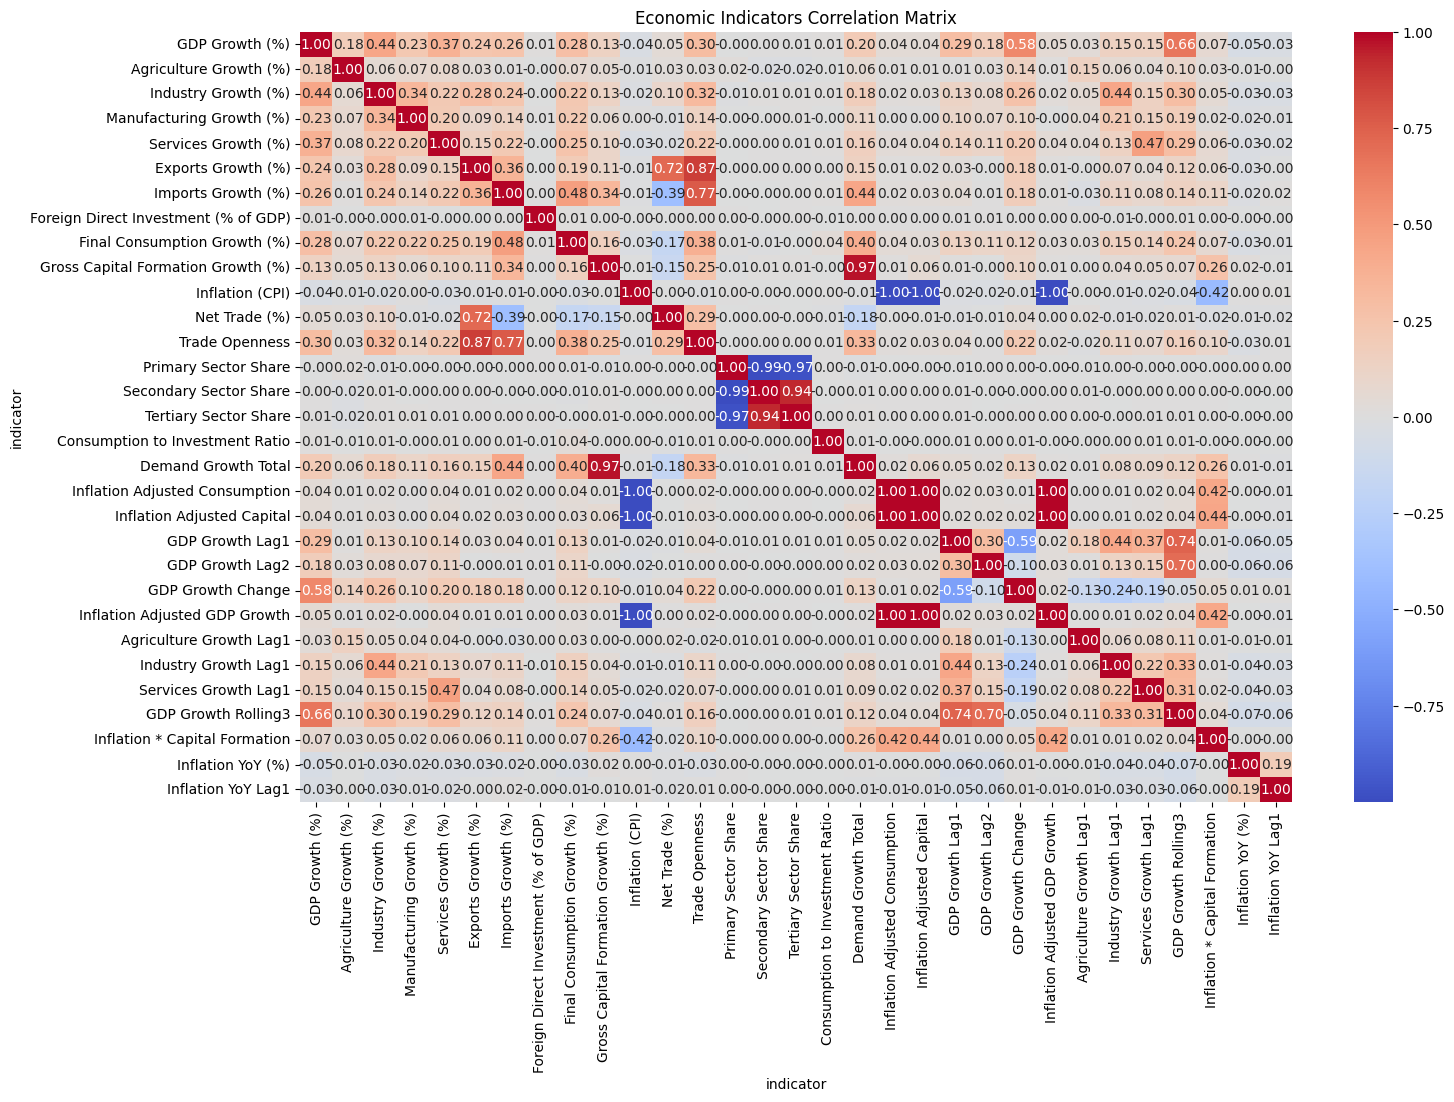


Top Positive Correlations with GDP Growth:
indicator
GDP Growth Rolling3    0.660747
GDP Growth Change      0.582144
Industry Growth (%)    0.435626
Services Growth (%)    0.373753
Trade Openness         0.299709
Name: GDP Growth (%), dtype: float64

Top Negative Correlations with GDP Growth:
indicator
Secondary Sector Share    0.003877
Primary Sector Share     -0.004488
Inflation YoY Lag1       -0.031798
Inflation (CPI)          -0.035208
Inflation YoY (%)        -0.047713
Name: GDP Growth (%), dtype: float64


In [ ]:
## 4. Correlation Analysis
print("\n" + "="*50)
print("Correlation Analysis")
print("="*50)

# Calculate correlations
if "Unemployment Rate (%)" in indicators:
    del indicators["Unemployment Rate (%)"]
if "GDP per person employed ($, PPP)" in indicators:
    del indicators["GDP per person employed ($, PPP)"]

numeric_columns = df_pivot.select_dtypes(include=['number']).columns
indicators_to_use = list(indicators.keys())
additional_features = [
    'Net Trade (%)', 'Trade Openness',
    'Primary Sector Share', 'Secondary Sector Share', 'Tertiary Sector Share',
    'Consumption to Investment Ratio', 'Demand Growth Total',
    'Inflation Adjusted Consumption', 'Inflation Adjusted Capital',
    'GDP Growth Lag1', 'GDP Growth Lag2', 'GDP Growth Change','Inflation Adjusted GDP Growth',
    'Agriculture Growth Lag1', 'Industry Growth Lag1', 'Services Growth Lag1',
    'GDP Growth Rolling3',
    'Inflation * Capital Formation', 'Inflation YoY (%)', 'Inflation YoY Lag1'
]

corr_columns = indicators_to_use + additional_features
corr_matrix = df_pivot[corr_columns].corr()

# Plot heatmap
plt.figure(figsize=(16, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt=".2f")
plt.title('Economic Indicators Correlation Matrix')
plt.show()

# Top correlations with GDP growth
gdp_corrs = corr_matrix['GDP Growth (%)'].sort_values(ascending=False)
print("\nTop Positive Correlations with GDP Growth:")
print(gdp_corrs[1:6])  # Skip GDP's correlation with itself
print("\nTop Negative Correlations with GDP Growth:")
print(gdp_corrs[-5:])

In [ ]:
print(gdp_corrs)

indicator
GDP Growth (%)                          1.000000
GDP Growth Rolling3                     0.660747
GDP Growth Change                       0.582144
Industry Growth (%)                     0.435626
Services Growth (%)                     0.373753
Trade Openness                          0.299709
GDP Growth Lag1                         0.292988
Final Consumption Growth (%)            0.281943
Imports Growth (%)                      0.256932
Exports Growth (%)                      0.241349
Manufacturing Growth (%)                0.225742
Demand Growth Total                     0.196016
Agriculture Growth (%)                  0.180239
GDP Growth Lag2                         0.178121
Services Growth Lag1                    0.146795
Industry Growth Lag1                    0.146714
Gross Capital Formation Growth (%)      0.134935
Inflation * Capital Formation           0.069095
Inflation Adjusted GDP Growth           0.047279
Net Trade (%)                           0.046072
Inflation 

# **Feature Selection**

In [ ]:
strong_features = [
    'Services Growth (%)',
    'Industry Growth (%)',
    'Final Consumption Growth (%)',
    'GDP Growth Change',
    'Trade Openness',
    'GDP Growth Lag1',
    'GDP Growth Rolling3',
    'Inflation YoY (%)',
    'Inflation YoY Lag1'
]

moderate_features = [
    'Exports Growth (%)',
    'Imports Growth (%)',
    'Gross Capital Formation Growth (%)',
    'Demand Growth Total',
    'Manufacturing Growth (%)',
    'Agriculture Growth (%)',
    'GDP Growth Lag2',
    'Services Growth Lag1',
    'Industry Growth Lag1'
]
selected_features = strong_features + moderate_features


# **Feature Transformation**

In [ ]:
skews = df_pivot.select_dtypes(include='number').skew().sort_values(ascending=False)
print(skews[abs(skews) > 1])  # Highly skewed

indicator
Secondary Sector Share                  112.501469
Tertiary Sector Share                   109.001402
Inflation YoY Lag1                       68.100222
Inflation YoY (%)                        68.098351
Inflation (CPI)                          66.885819
Manufacturing Growth (%)                 24.249491
Exports Growth (%)                       18.773432
Final Consumption Growth (%)             17.490339
Foreign Direct Investment (% of GDP)     17.439524
Net Trade (%)                            15.432675
Agriculture Growth Lag1                  12.654790
Agriculture Growth (%)                   12.438590
Trade Openness                            8.822276
Demand Growth Total                       5.500376
Gross Capital Formation Growth (%)        5.062937
Services Growth Lag1                      4.207816
Services Growth (%)                       3.856243
Industry Growth Lag1                      2.456697
Industry Growth (%)                       2.431174
Imports Growth (%)   

In [ ]:
from sklearn.preprocessing import QuantileTransformer

# Copy and clean the data first
df_quantile = df_pivot.copy()
df_quantile.replace([np.inf, -np.inf], np.nan, inplace=True)
df_quantile.dropna(inplace=True)

# Apply QuantileTransformer
numeric_cols = df_quantile.select_dtypes(include='number').columns
qt = QuantileTransformer(output_distribution='normal', random_state=42)
df_quantile[numeric_cols] = qt.fit_transform(df_quantile[numeric_cols])


In [ ]:
from scipy.stats import skew

print("\nSkewness after Quantile Transformation:")
for col in numeric_cols:
    print(f"{col}: {skew(df_quantile[col]):.2f}")



Skewness after Quantile Transformation:
Year: 0.43
Agriculture Growth (%): -0.16
Exports Growth (%): -0.00
Final Consumption Growth (%): -0.02
Foreign Direct Investment (% of GDP): 0.00
GDP Growth (%): 0.01
Gross Capital Formation Growth (%): 0.01
Imports Growth (%): -0.00
Industry Growth (%): -0.01
Inflation (CPI): -0.51
Manufacturing Growth (%): -0.02
Services Growth (%): -0.00
Decade: -0.18
Net Trade (%): 0.01
Trade Openness: 0.01
Primary Sector Share: 0.00
Secondary Sector Share: 0.01
Tertiary Sector Share: -0.03
Consumption to Investment Ratio: 0.12
Demand Growth Total: 0.02
Inflation Adjusted Consumption: -0.01
Inflation Adjusted Capital: 0.00
GDP Growth Lag1: 0.01
GDP Growth Lag2: -0.00
GDP Growth Rolling3: 0.00
GDP Growth Change: 0.01
Inflation * Capital Formation: -0.00
Inflation YoY (%): 0.00
Inflation Adjusted GDP Growth: -0.00
Agriculture Growth Lag1: -0.01
Industry Growth Lag1: 0.01
Services Growth Lag1: -0.01
Inflation YoY Lag1: 0.02


In [ ]:
df_pivot.to_csv("WDI_data.csv", index=False)

In [ ]:
df = pd.read_csv("WDI_data.csv")

In [ ]:
print(df.columns)


Index(['Country', 'Year', 'Agriculture Growth (%)', 'Exports Growth (%)',
       'Final Consumption Growth (%)', 'Foreign Direct Investment (% of GDP)',
       'GDP Growth (%)', 'Gross Capital Formation Growth (%)',
       'Imports Growth (%)', 'Industry Growth (%)', 'Inflation (CPI)',
       'Manufacturing Growth (%)', 'Services Growth (%)', 'Decade',
       'Net Trade (%)', 'Trade Openness', 'Primary Sector Share',
       'Secondary Sector Share', 'Tertiary Sector Share',
       'Consumption to Investment Ratio', 'Demand Growth Total',
       'Inflation Adjusted Consumption', 'Inflation Adjusted Capital',
       'GDP Growth Lag1', 'GDP Growth Lag2', 'GDP Growth Rolling3',
       'GDP Growth Change', 'Inflation * Capital Formation',
       'Inflation Adjusted GDP Growth', 'Agriculture Growth Lag1',
       'Industry Growth Lag1', 'Services Growth Lag1'],
      dtype='object')


# **Splitting the data**

In [ ]:
from sklearn.model_selection import train_test_split

# Assuming df_quantile is your transformed DataFrame with all features
# Replace 'target_column' with the name of your target variable, like 'GDP Growth (%)'
X = df_quantile.drop(columns=['GDP Growth (%)'])  # Features
y = df_quantile['GDP Growth (%)']  # Target

# Step 1: Split the data into Train + Test (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Step 2: Split the Train set further into Train + Validation (80% train, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Check the sizes of the splits
print(f"Training Set: {X_train.shape[0]} samples")
print(f"Validation Set: {X_val.shape[0]} samples")
print(f"Test Set: {X_test.shape[0]} samples")


Training Set: 7764 samples
Validation Set: 1941 samples
Test Set: 4160 samples


# **Encoding the categorical data**

In [ ]:
# One-hot encode 'Country' AFTER splitting
X_train = pd.get_dummies(X_train, columns=['Country'], drop_first=True)
X_val = pd.get_dummies(X_val, columns=['Country'], drop_first=True)
X_test = pd.get_dummies(X_test, columns=['Country'], drop_first=True)

# Align columns to ensure train, val, test have the same columns
X_val = X_val.reindex(columns=X_train.columns, fill_value=0)
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)


# **Model Training**

## **Linear Model**

Root Mean Squared Error: 0.3197
Mean Squared Error: 0.10223805475698146
R-squared: 0.8994372861364741


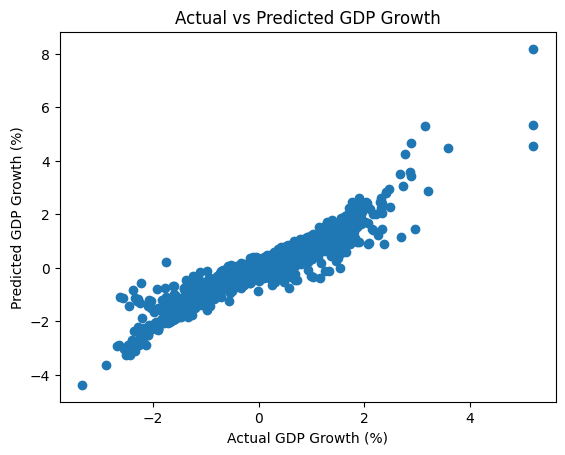

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Initialize the model
linear_model = LinearRegression()

# Train the model on the training set
linear_model.fit(X_train, y_train)

# Predict on the validation set
y_pred = linear_model.predict(X_val)

# Evaluate the model
mse = mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)
rmse = mse ** 0.5
print(f"Root Mean Squared Error: {rmse:.4f}")
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

# Optionally, visualize predictions vs actual
import matplotlib.pyplot as plt
plt.scatter(y_val, y_pred)
plt.xlabel("Actual GDP Growth (%)")
plt.ylabel("Predicted GDP Growth (%)")
plt.title("Actual vs Predicted GDP Growth")
plt.show()


In [ ]:
y_test_pred = linear_model.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)
print(f"Test MSE: {test_mse:.4f}")
print(f"Test R²: {test_r2:.4f}")


Test MSE: 0.1120
Test R²: 0.8897


In [ ]:
from sklearn.linear_model import Ridge, Lasso

ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)
ridge_pred = ridge.predict(X_test)
print("Ridge R²:", r2_score(y_test, ridge_pred))

lasso = Lasso(alpha=0.1)
lasso.fit(X_train, y_train)
lasso_pred = lasso.predict(X_test)
print("Lasso R²:", r2_score(y_test, lasso_pred))


Ridge R²: 0.8901948883877684
Lasso R²: 0.8000436889203729


## **Random Forest Model**

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Initialize the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model on the training set
rf_model.fit(X_train, y_train)

# Predict on the validation set
y_val_pred = rf_model.predict(X_val)

# Evaluate the model on validation set
val_mse = mean_squared_error(y_val, y_val_pred)
val_r2 = r2_score(y_val, y_val_pred)

print(f"Validation MSE: {val_mse:.4f}")
print(f"Validation R²: {val_r2:.4f}")


Validation MSE: 0.0448
Validation R²: 0.9559


In [ ]:
# Predict on the test set
y_test_pred = rf_model.predict(X_test)

# Evaluate the model on test set
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"Test MSE: {test_mse:.4f}")
print(f"Test R²: {test_r2:.4f}")


Test MSE: 0.0491
Test R²: 0.9516


## **Gradient Boosting Model**

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Initialize the model
gb_model = GradientBoostingRegressor(random_state=42)

# Train the model on the training set
gb_model.fit(X_train, y_train)

# Predict on the validation set
y_val_pred = gb_model.predict(X_val)

# Evaluate the model on validation set
val_mse = mean_squared_error(y_val, y_val_pred)
val_r2 = r2_score(y_val, y_val_pred)

print(f"Validation MSE: {val_mse:.4f}")
print(f"Validation R²: {val_r2:.4f}")


Validation MSE: 0.0615
Validation R²: 0.9395


In [ ]:
# Test the model
y_test_pred = gb_model.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"Test MSE: {test_mse:.4f}")
print(f"Test R²: {test_r2:.4f}")

Test MSE: 0.0673
Test R²: 0.9337


## **XGBoost Model**

In [ ]:
import xgboost as xgb
from xgboost import XGBRegressor

# Convert data into DMatrix format (specific to XGBoost)
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test, label=y_test)

# Set up the parameters for the XGBoost model
params = {
    'objective': 'reg:squarederror',  # Regression task
    'eval_metric': 'rmse',            # RMSE for evaluation
    'max_depth': 6,
    'learning_rate': 0.1,
    'n_estimators': 100
}

# Train the XGBoost model
xg_model = xgb.train(params, dtrain, num_boost_round=100, evals=[(dval, 'eval')])

# Predict on the test set
y_test_pred_xgb = xg_model.predict(dtest)

# Evaluate the model
test_mse_xgb = mean_squared_error(y_test, y_test_pred_xgb)
test_r2_xgb = r2_score(y_test, y_test_pred_xgb)

print(f"XGBoost Test MSE: {test_mse_xgb:.4f}")
print(f"XGBoost Test R²: {test_r2_xgb:.4f}")


[0]	eval-rmse:0.93310
[1]	eval-rmse:0.86179


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[02:08:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.




[2]	eval-rmse:0.80166
[3]	eval-rmse:0.74570
[4]	eval-rmse:0.69732
[5]	eval-rmse:0.65264
[6]	eval-rmse:0.61145
[7]	eval-rmse:0.57435
[8]	eval-rmse:0.54160
[9]	eval-rmse:0.51241
[10]	eval-rmse:0.48537
[11]	eval-rmse:0.46175
[12]	eval-rmse:0.44003
[13]	eval-rmse:0.41849
[14]	eval-rmse:0.40106
[15]	eval-rmse:0.38349
[16]	eval-rmse:0.36750
[17]	eval-rmse:0.35386
[18]	eval-rmse:0.34161
[19]	eval-rmse:0.32790
[20]	eval-rmse:0.31909
[21]	eval-rmse:0.31033
[22]	eval-rmse:0.30362
[23]	eval-rmse:0.29753
[24]	eval-rmse:0.29074
[25]	eval-rmse:0.28600
[26]	eval-rmse:0.27957
[27]	eval-rmse:0.27460
[28]	eval-rmse:0.27071
[29]	eval-rmse:0.26720
[30]	eval-rmse:0.26198
[31]	eval-rmse:0.25897
[32]	eval-rmse:0.25485
[33]	eval-rmse:0.25059
[34]	eval-rmse:0.24675
[35]	eval-rmse:0.24432
[36]	eval-rmse:0.24254
[37]	eval-rmse:0.24025
[38]	eval-rmse:0.23754
[39]	eval-rmse:0.23624
[40]	eval-rmse:0.23510
[41]	eval-rmse:0.23203
[42]	eval-rmse:0.23066
[43]	eval-rmse:0.22943
[44]	eval-rmse:0.22854
[45]	eval-rmse:0.22

# **Model Evaluation**

In [ ]:
models = {
    'Linear Regression': linear_model,
    'Ridge': ridge,
    'Lasso': lasso,
    'Random Forest': rf_model,
    'Gradient Boosting': gb_model
}

for name, model in models.items():
    y_val_pred = model.predict(X_val)
    y_test_pred = model.predict(X_test)
    print(f"\n{name}")
    print(f"Validation MSE: {mean_squared_error(y_val, y_val_pred):.4f}")
    print(f"Validation R²: {r2_score(y_val, y_val_pred):.4f}")
    print(f"Test MSE: {mean_squared_error(y_test, y_test_pred):.4f}")
    print(f"Test R²: {r2_score(y_test, y_test_pred):.4f}")


Linear Regression
Validation MSE: 0.1022
Validation R²: 0.8994
Test MSE: 0.1120
Test R²: 0.8897

Ridge
Validation MSE: 0.1025
Validation R²: 0.8992
Test MSE: 0.1115
Test R²: 0.8902

Lasso
Validation MSE: 0.1939
Validation R²: 0.8093
Test MSE: 0.2030
Test R²: 0.8000

Random Forest
Validation MSE: 0.0448
Validation R²: 0.9559
Test MSE: 0.0491
Test R²: 0.9516

Gradient Boosting
Validation MSE: 0.0615
Validation R²: 0.9395
Test MSE: 0.0673
Test R²: 0.9337


# **Tuning Hyperparameters**

## **Ridge Regressor**

In [ ]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import GridSearchCV

# Ridge Regression Hyperparameters
ridge_params = {
    'alpha': [0.01, 0.1, 1, 10, 100]
}


# Grid Search for Ridge
ridge_grid = GridSearchCV(Ridge(), ridge_params, cv=5, scoring='neg_mean_squared_error')
ridge_grid.fit(X_train, y_train)
print(f"Best Ridge Model: {ridge_grid.best_params_}")
print(f"Best Ridge Score: {ridge_grid.best_score_}")


Best Ridge Model: {'alpha': 10}
Best Ridge Score: -0.10710042734380254


## **Lasso Regressor**

In [ ]:
# Lasso Regression Hyperparameters
lasso_params = {
    'alpha': [0.01, 0.1, 1, 10, 100]
}

# Grid Search for Lasso
lasso_grid = GridSearchCV(Lasso(), lasso_params, cv=5, scoring='neg_mean_squared_error')
lasso_grid.fit(X_train, y_train)
print(f"Best Lasso Model: {lasso_grid.best_params_}")
print(f"Best Lasso Score: {lasso_grid.best_score_}")

Best Lasso Model: {'alpha': 0.01}
Best Lasso Score: -0.1219824892740294


## **Random Forest Regressor**

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

# Hyperparameters for Random Forest
rf_model = RandomForestRegressor(random_state=42)
rf_param_grid = {
    'n_estimators': [100, 200, 300,400,500],
    'max_depth': [ 10, 20, 30,None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [ 'sqrt', 'log2',None]
}

rf_random = RandomizedSearchCV(estimator=rf_model,
                                param_distributions=rf_param_grid,
                                n_iter=50,
                                cv=5,
                                scoring='r2',
                                verbose=1,
                                random_state=42,
                                n_jobs=-1)
rf_random.fit(X_train, y_train)
print("Best RF Parameters:", rf_random.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best RF Parameters: {'n_estimators': 400, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': 30}


In [ ]:
best_rf_params = {
    'n_estimators': 400,
    'min_samples_split': 5,
    'min_samples_leaf': 2,
    'max_features': None,
    'max_depth': 30
}
# Initialize model with best parameters
best_rf_model = RandomForestRegressor(**best_rf_params, random_state=42)
best_rf_model.fit(X_train, y_train)

# Validation predictions
val_preds = best_rf_model.predict(X_val)
val_mse = mean_squared_error(y_val, val_preds)
val_r2 = r2_score(y_val, val_preds)

# Test predictions
test_preds = best_rf_model.predict(X_test)
test_mse = mean_squared_error(y_test, test_preds)
test_r2 = r2_score(y_test, test_preds)

print("✅ Random Forest - Tuned Results")
print(f"Validation MSE: {val_mse:.4f}")
print(f"Validation R²: {val_r2:.4f}")
print(f"Test MSE: {test_mse:.4f}")
print(f"Test R²: {test_r2:.4f}")


✅ Random Forest - Tuned Results
Validation MSE: 0.0448
Validation R²: 0.9560
Test MSE: 0.0486
Test R²: 0.9521


## **Gradient Boosting Regressor**

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

# Hyperparameters for Gradient Boosting
gb_model = GradientBoostingRegressor(random_state=42)
gb_param_grid = {
    'n_estimators': [100, 200, 300,400],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

gb_random = RandomizedSearchCV(estimator=gb_model,
                                param_distributions=gb_param_grid,
                                n_iter=50,
                                cv=5,
                                scoring='r2',
                                verbose=1,
                                random_state=42,
                                n_jobs=-1)
gb_random.fit(X_train, y_train)
print("Best GB Parameters:", gb_random.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best GB Parameters: {'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_depth': 7, 'learning_rate': 0.1}


In [ ]:
# Initialize the best GB model with tuned parameters
best_gb = GradientBoostingRegressor(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=7,
    min_samples_split=10,
    min_samples_leaf=4,
    random_state=42
)

# Fit on training data
best_gb.fit(X_train, y_train)

# Evaluate on validation set
val_pred_gb = best_gb.predict(X_val)
val_mse_gb = mean_squared_error(y_val, val_pred_gb)
val_r2_gb = r2_score(y_val, val_pred_gb)

# Evaluate on test set
test_pred_gb = best_gb.predict(X_test)
test_mse_gb = mean_squared_error(y_test, test_pred_gb)
test_r2_gb = r2_score(y_test, test_pred_gb)

print("Gradient Boosting - Tuned Results")
print(f"Validation MSE: {val_mse_gb:.4f}")
print(f"Validation R²: {val_r2_gb:.4f}")
print(f"Test MSE: {test_mse_gb:.4f}")
print(f"Test R²: {test_r2_gb:.4f}")


Gradient Boosting - Tuned Results
Validation MSE: 0.0309
Validation R²: 0.9696
Test MSE: 0.0390
Test R²: 0.9615


## **XGBoost Regressor**

In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV # Import RandomizedSearchCV

# Hyperparameters for XGBoost
xgb_model = XGBRegressor(random_state=42, objective='reg:squarederror')
xgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 10],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

xgb_random = RandomizedSearchCV(estimator=xgb_model,
                                 param_distributions=xgb_param_grid,
                                 n_iter=50,
                                 cv=5,
                                 scoring='r2',
                                 verbose=1,
                                 random_state=42,
                                 n_jobs=-1)
xgb_random.fit(X_train, y_train)
print("Best XGB Parameters:", xgb_random.best_params_)


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best XGB Parameters: {'subsample': 0.6, 'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.05, 'colsample_bytree': 0.8}


In [ ]:
# Train the tuned XGBoost model
xgb_best = XGBRegressor(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.6,
    colsample_bytree=0.8,
    random_state=42
)

xgb_best.fit(X_train, y_train)

# Validation performance
xgb_val_pred = xgb_best.predict(X_val)
xgb_val_mse = mean_squared_error(y_val, xgb_val_pred)
xgb_val_r2 = r2_score(y_val, xgb_val_pred)

# Test performance
xgb_test_pred = xgb_best.predict(X_test)
xgb_test_mse = mean_squared_error(y_test, xgb_test_pred)
xgb_test_r2 = r2_score(y_test, xgb_test_pred)

print("XGBoost - Tuned Results")
print(f"Validation MSE: {xgb_val_mse:.4f}")
print(f"Validation R²: {xgb_val_r2:.4f}")
print(f"Test MSE: {xgb_test_mse:.4f}")
print(f"Test R²: {xgb_test_r2:.4f}")


XGBoost - Tuned Results
Validation MSE: 0.0409
Validation R²: 0.9597
Test MSE: 0.0402
Test R²: 0.9604


# **Save the model**

In [ ]:
import joblib

joblib.dump(linear_model, f'{model_dir}/linear_model.pkl')
joblib.dump(ridge_grid.best_estimator_, f'{model_dir}/ridge_model.pkl')
joblib.dump(lasso_grid.best_estimator_, f'{model_dir}/lasso_model.pkl')
joblib.dump(best_rf_model, f'{model_dir}/random_forest_model.pkl')
joblib.dump(best_gb, f'{model_dir}/gradient_boosting_model.pkl')
joblib.dump(xgb_best, f'{model_dir}/xgboost_model.pkl')

print("✅ All models saved to Google Drive.")


✅ All models saved to Google Drive.


# **Visualiation**

## **Actual vs Predicted Plot (on Test Set)**

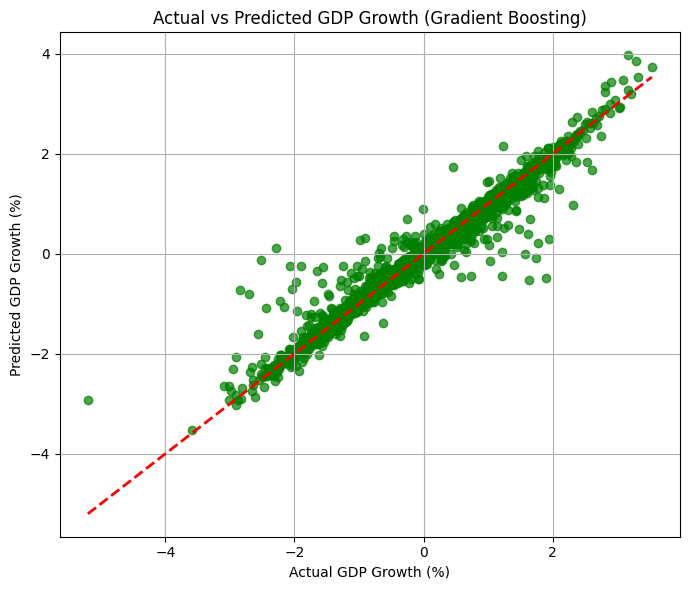

In [ ]:
import matplotlib.pyplot as plt

y_test_pred = best_gb.predict(X_test)

plt.figure(figsize=(7, 6))
plt.scatter(y_test, y_test_pred, alpha=0.7, color='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2)
plt.xlabel("Actual GDP Growth (%)")
plt.ylabel("Predicted GDP Growth (%)")
plt.title("Actual vs Predicted GDP Growth (Gradient Boosting)")
plt.grid(True)
plt.tight_layout()
plt.show()

## **Residual Plot**

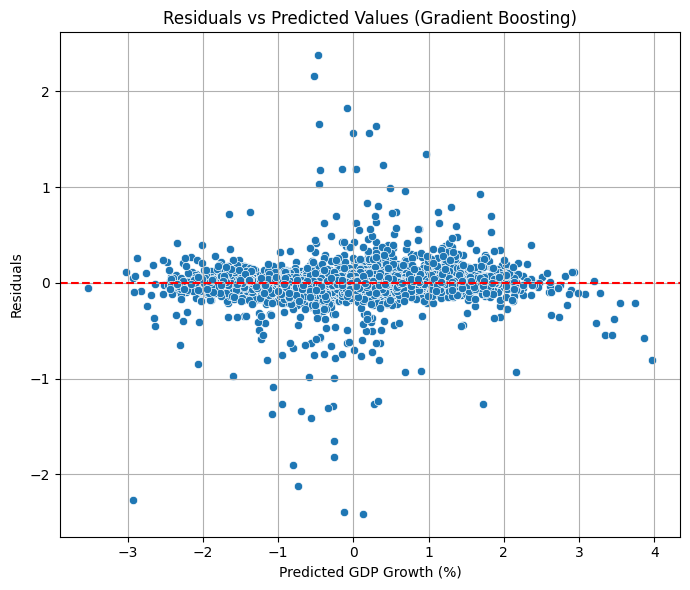

In [ ]:
import seaborn as sns

residuals = y_test - y_test_pred

plt.figure(figsize=(7, 6))
sns.scatterplot(x=y_test_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted GDP Growth (%)")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted Values (Gradient Boosting)")
plt.grid(True)
plt.tight_layout()
plt.show()


## **Distribution of Residuals**

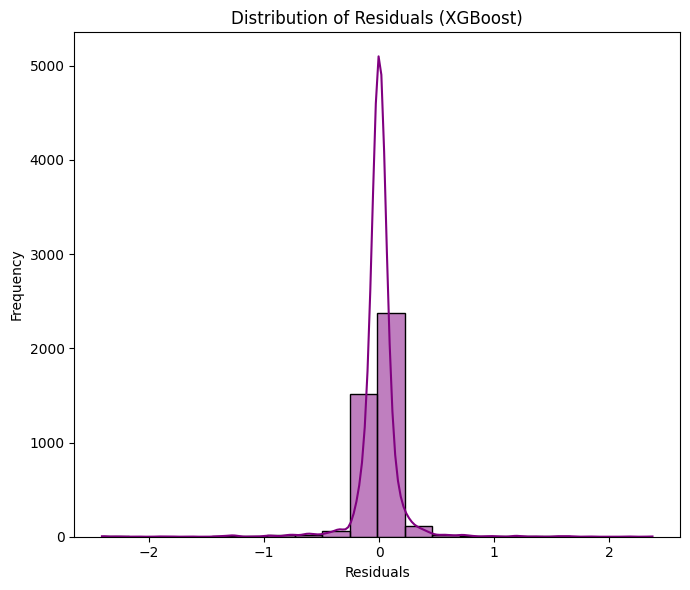

In [ ]:
plt.figure(figsize=(7, 6))
sns.histplot(residuals, kde=True, bins=20, color='purple')
plt.title("Distribution of Residuals (XGBoost)")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


## **Feature Importance**

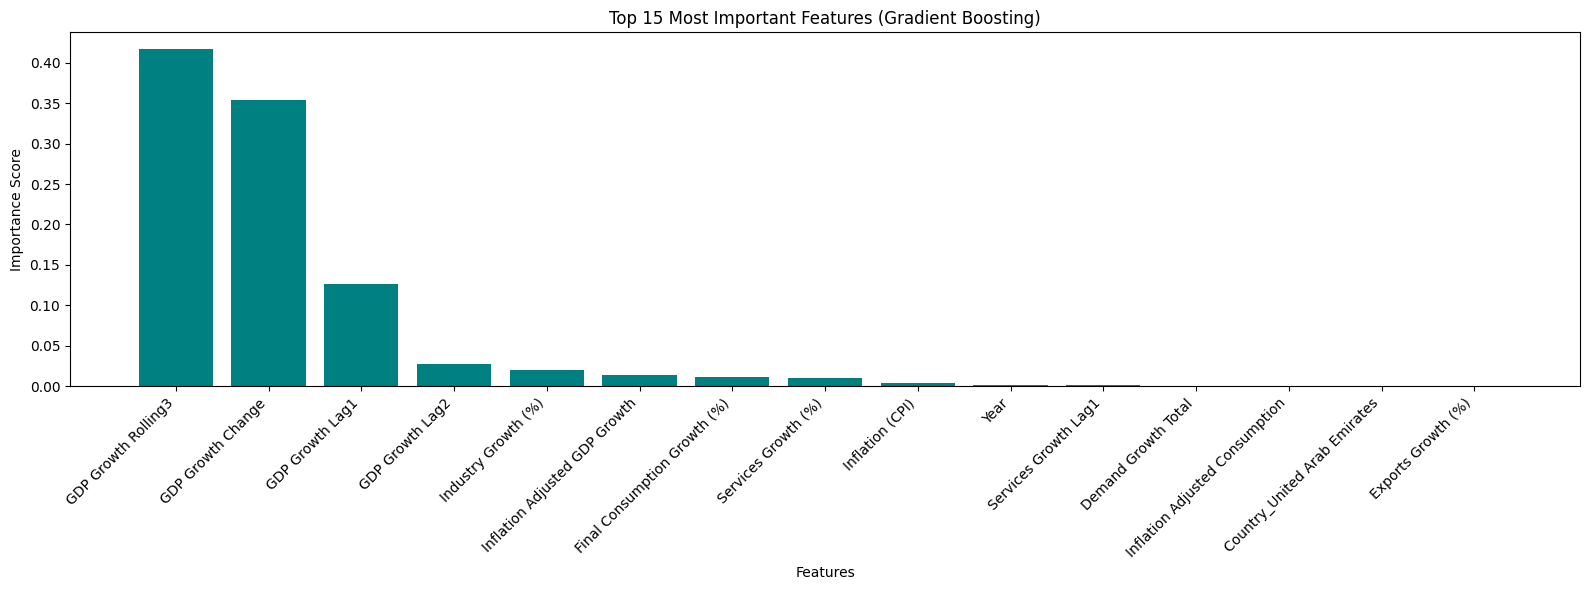

In [ ]:
importances = best_gb.feature_importances_
indices = np.argsort(importances)[::-1][:15]
feature_names = X_train.columns[indices]

plt.figure(figsize=(16, 6))
plt.bar(range(len(indices)), importances[indices], color='teal', align='center')
plt.xticks(range(len(indices)), feature_names, rotation=45, ha='right')
plt.title('Top 15 Most Important Features (Gradient Boosting)')
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.tight_layout()
plt.show()


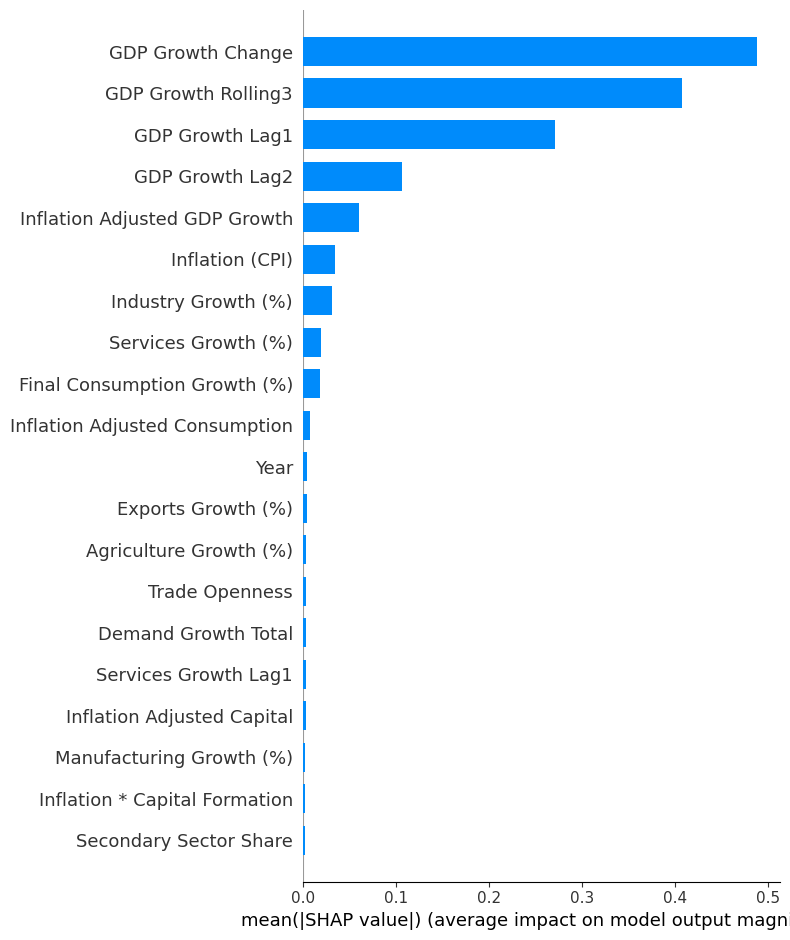

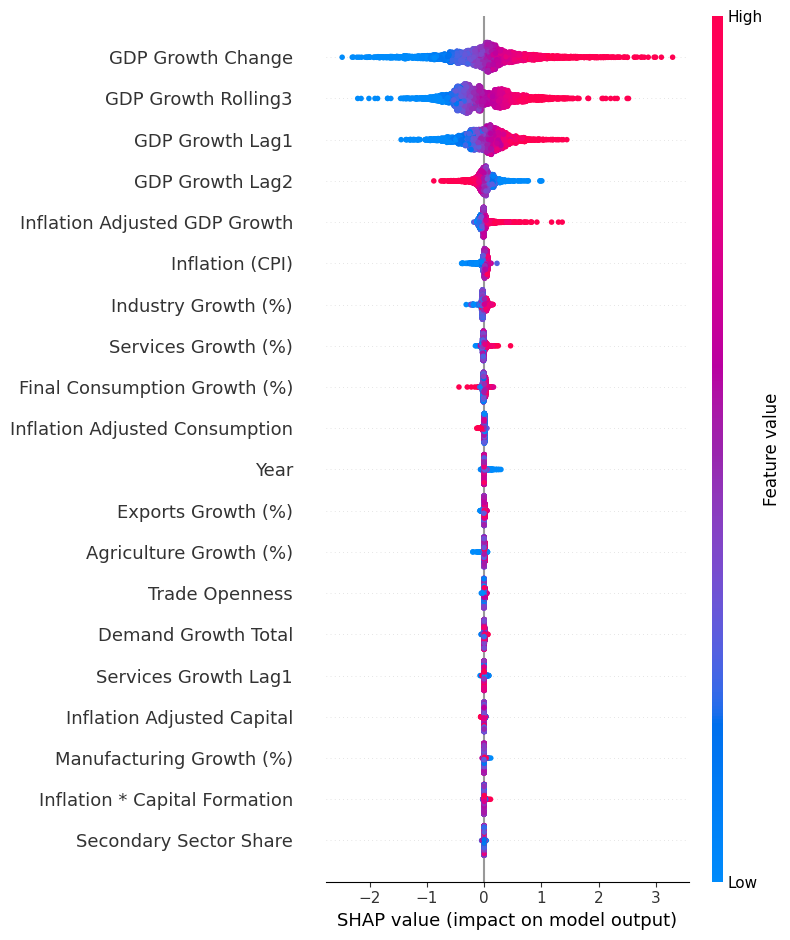

In [ ]:
import shap

explainer = shap.Explainer(best_gb)
shap_values = explainer(X_test)

# Summary plot
shap.summary_plot(shap_values, X_test, plot_type="bar")
shap.summary_plot(shap_values, X_test)
